In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')

import json, unicodedata, os

from collections import Counter

import networkx as nx

from scipy.spatial.distance import euclidean, cosine

#_dir = '/Users/briankeegan/Dropbox/Workspace/Wikipedia_images/'
_dir = 'E:/Dropbox/Workspace/Wikipedia_images/'

In [2]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

## Coup baseline analysis

In [3]:
historical_coups_df = pd.read_csv('coups_by_country.txt',sep='\t')
historical_coups_df['date'] = pd.to_datetime(historical_coups_df.apply(lambda x:'{0:02d}-{1:02d}-{2:02d}'.format(x['year'],x['month'],x['day']),axis=1))
historical_coups_df.head()

,country,ccode,year,month,day,coup,version,date
0,Cuba,40,1952,3,10,2,V2016.07.20,1952-03-10
1,Cuba,40,1957,9,5,1,V2016.07.20,1957-09-05
2,Haiti,41,1950,5,10,2,V2016.07.20,1950-05-10
3,Haiti,41,1956,12,12,2,V2016.07.20,1956-12-12
4,Haiti,41,1957,4,2,2,V2016.07.20,1957-04-02


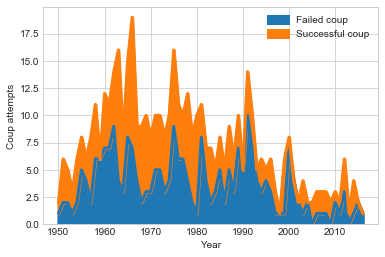

In [4]:
annual_coups_df = historical_coups_df.groupby(['year','coup']).agg({'country':len})['country'].unstack().fillna(0)
annual_coups_df.rename(columns={1:'Failed coup',2:'Successful coup'},inplace=True)

# Plot
ax = annual_coups_df.plot(kind='area',stacked=True,legend=False,lw=3)
ax.set_xlabel('Year')
ax.set_ylabel('Coup attempts')
#ax.set_ylim((0,18))
ax.legend()

In [5]:
historical_coups_df.groupby('country').agg({'year':[np.min,np.max,len]})['year'].sort_values('amax',ascending=False).head()

,amin,amax,len
country,,,
Turkey,1960,2016,6
Burkina Faso,1966,2015,8
Burundi,1965,2015,11
Ukraine,2014,2014,1
Lesotho,1986,2014,4


## Coup revisions

In [6]:
rev_df = pd.read_csv('all_coups_revisions.csv',encoding='utf8')
rev_df['timestamp'] = pd.to_datetime(rev_df['timestamp'],format='%Y-%m-%dT%H:%M:%SZ')
rev_df['year'] = rev_df['timestamp'].apply(lambda x:x.year)
rev_df.head()

/Users/emilyporter/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parent_topic,anon,lang,page,parentid,rev_num,revid,sha1,sha1hidden,size,timestamp,user,userhidden,year
0,1979 Equatorial Guinea coup d'état,NaN,fr,Coup d'État de 1979 en Guinée équatoriale,130702092,0,130707374,ab4b056d773524c4c4a6c7b0e5fbd67a75a84e05,NaN,602,2016-10-15 21:21:17,OrlodrimBot,NaN,2016
1,1979 Equatorial Guinea coup d'état,NaN,fr,Coup d'État de 1979 en Guinée équatoriale,130702041,1,130702092,8b540a85b0754eade080782115c37907dc6b7f91,NaN,592,2016-10-15 18:39:13,Rashinseita,NaN,2016
2,1979 Equatorial Guinea coup d'état,NaN,fr,Coup d'État de 1979 en Guinée équatoriale,0,2,130702041,78f5fe6f240741c4b77c760a61ce5dd857aa167c,NaN,566,2016-10-15 18:37:36,Rashinseita,NaN,2016
3,1979 Equatorial Guinea coup d'état,NaN,es,Golpe de Estado en Guinea Ecuatorial de 1979,97851838,0,97871893,867199a33b32a94e9e42beada8bc17ecdfa4dff0,NaN,128875,2017-03-26 21:41:13,Marval703,NaN,2017
4,1979 Equatorial Guinea coup d'état,NaN,es,Golpe de Estado en Guinea Ecuatorial de 1979,97851124,1,97851838,587c16af7a77b63fa4ab615dc59ba8b1c9e686f9,NaN,128456,2017-03-26 03:20:30,Marval703,NaN,2017


In [7]:
len(rev_df['page'].unique()), len(rev_df['parent_topic'].unique()), len(rev_df['lang'].unique())

(1137, 169, 97)

In [8]:
_agg_func = {'user':pd.Series.nunique,'sha1':pd.Series.nunique,'size':np.max,'timestamp':np.min, 'year':np.min}
summary_df = rev_df.groupby(['parent_topic','page']).agg(_agg_func)
summary_df.rename(columns={'sha1':'Revisions','user':'Editors','size':'Size', 'year':'Year'},inplace=True)
summary_df = summary_df.median(level=0)

summary_df['Languages'] = rev_df.groupby('parent_topic').agg({'lang':pd.Series.nunique}).sort_values('lang',ascending=False)['lang']

summary_df = summary_df[['Languages','Revisions','Editors','Size','Year']]
summary_df.sort_values('Languages',ascending=False).head(10)

,Languages,Revisions,Editors,Size,Year
parent_topic,,,,,
2016 Turkish coup d'état attempt,61,25.0,7.0,14397.0,2016.0
Carnation Revolution,44,41.0,24.0,7376.0,2007.0
1991 Soviet coup d'état attempt,43,51.0,30.5,14353.0,2009.0
Romanian Revolution,39,67.0,32.0,12880.0,2007.5
1973 Chilean coup d'état,31,37.0,20.0,9632.0,2011.0
2013 Egyptian coup d'état,31,32.0,13.0,13820.0,2013.0
Tulip Revolution,28,34.0,21.0,4775.0,2007.0
1953 Iranian coup d'état,28,59.0,26.0,8404.0,2009.0
1993 Russian constitutional crisis,28,35.5,22.0,11048.5,2010.0


In [9]:
print(summary_df.sort_values('Languages',ascending=False).head(10).to_latex(encoding='ascii'))

\begin{tabular}{lrrrrr}
\toprule
{} &  Languages &  Revisions &  Editors &     Size &    Year \\
parent\_topic                       &            &            &          &          &         \\
\midrule
2016 Turkish coup d'état attempt   &         61 &       25.0 &      7.0 &  14397.0 &  2016.0 \\
Carnation Revolution               &         44 &       41.0 &     24.0 &   7376.0 &  2007.0 \\
1991 Soviet coup d'état attempt    &         43 &       51.0 &     30.5 &  14353.0 &  2009.0 \\
Romanian Revolution                &         39 &       67.0 &     32.0 &  12880.0 &  2007.5 \\
1973 Chilean coup d'état           &         31 &       37.0 &     20.0 &   9632.0 &  2011.0 \\
2013 Egyptian coup d'état          &         31 &       32.0 &     13.0 &  13820.0 &  2013.0 \\
Tulip Revolution                   &         28 &       34.0 &     21.0 &   4775.0 &  2007.0 \\
1953 Iranian coup d'état           &         28 &       59.0 &     26.0 &   8404.0 &  2009.0 \\
1993 Russian constitutional c

## Inter-language links

In [10]:
with open("all_coups_interlanguage_links.json",'r') as f:
    coup_interlanguage_links = json.load(f)

In [11]:
articles_across_languages_count = 0
languages_represented = set()
for topic, topic_d in coup_interlanguage_links.items():
    articles_across_languages_count += len(topic_d)
    languages_represented = languages_represented | set(topic_d.keys())
print("There are {0:,} articles across {1:,} languages about the {2:,} seed topics".format(articles_across_languages_count,
                                                                                           len(languages_represented),
                                                                                           len(coup_interlanguage_links)))

There are 1,164 articles across 97 languages about the 168 seed topics


In [12]:
ill_counts_d = {}

for topic, topic_d in coup_interlanguage_links.items():
    ill_counts_d[topic] = {}
    for lang, lang_d in topic_d.items():
        ill_counts_d[topic][lang] = len(lang_d)

topic_lang_links_df = pd.DataFrame(ill_counts_d).stack().reset_index()
topic_lang_links_df.columns = ['lang','topic','link count']
topic_lang_links_df.head()

,lang,topic,link count
0,af,2013 Egyptian coup d'état,2.0
1,am,1960 Ethiopian coup attempt,64.0
2,ar,17 July Revolution,12.0
3,ar,1953 Colombian coup d'état,5.0
4,ar,1953 Iranian coup d'état,30.0


## Categories

In [13]:
with open('commons_category_file_members.json','r') as f:
    commons_category_file_members_dict = json.load(f)
    
with open('all_coups_file_image_usage.json','r') as f:
    all_coups_image_usage = json.load(f)

In [14]:
all_coups_image_usage["1987 Fijian coups d'état"]['en']

{'File:Arms of Fiji 2.png': ['History of Fiji',
  "Timeline of the 2000 Fijian coup d'état",
  "1987 Fijian coups d'état",
  'Fiji Week, 2004',
  '1977 Fijian constitutional crisis',
  "2000 Fijian coup d'état",
  "Mutinies of the 2000 Fijian coup d'état",
  "Aftermath of the 2000 Fijian coup d'état",
  'Discovery of Fiji',
  'Fiji during the time of Cakobau',
  'Colony of Fiji',
  'Modern history of Fiji',
  'Nuanced voices on the Reconciliation, Tolerance, and Unity Bill',
  'Yellow Ribbon campaign (Fiji)',
  'Blue Ribbon campaign (Fiji)',
  "Military unrest following the 2000 Fijian coup d'état",
  'Military opposition to the Reconciliation, Tolerance, and Unity Bill',
  'Fiji Week, 2005',
  "Investigations since the 2000 Fijian coup d'état",
  "Trials since the 2000 Fijian coup d'état",
  'Military–church relations in Fiji',
  'International reaction to the Reconciliation, Tolerance, and Unity Bill',
  'Reconciliation, Tolerance, and Unity Bill',
  'Fijian mercenaries in Bougainvil

In [15]:
_s1 = pd.Series({cat:len(members) for cat, members in commons_category_file_members_dict.items()})
hist1 = np.histogram(_s1.values,bins=np.logspace(0,5,31))
hist1_s = pd.Series(dict(zip(hist1[1][1:],hist1[0])))

In [16]:
image_count_by_lang = {}
for topic, topic_d in all_coups_image_usage.items():
    for lang, lang_d in topic_d.items():
        for file, filelist in lang_d.items():
            try:
                image_count_by_lang[file.split(':')[1]] += 1
            except KeyError:
                image_count_by_lang[file.split(':')[1]] = 1
                
hist2_s = pd.Series(image_count_by_lang)
hist2_s = hist2_s.value_counts().sort_index()

In [17]:
pd.Series(image_count_by_lang).sort_values(ascending=False).head()

Romanian Revolution 1989 Demonstrators.jpg      25
Golpe de Estado 1973.jpg                        25
Coruche mural 25 Abril.jpg                      21
Boris Yeltsin 19 August 1991-1.jpg              21
Thai-coup-detat-2014-social-media-banner.jpg    20
dtype: int64

In [18]:
image_usage_across_project = {}
for topic, topic_d in all_coups_image_usage.items():
    for lang, lang_d in topic_d.items():
        for file, filelist in lang_d.items():
            try:
                image_usage_across_project[file.split(':')[1]] += len(filelist)
            except KeyError:
                image_usage_across_project[file.split(':')[1]] = len(filelist)
                
hist3_s = pd.Series(image_usage_across_project)
hist3_s = hist3_s.value_counts().sort_index()

pd.Series(image_usage_across_project).sort_values(ascending=False).head()

Apollo 11.jpg                                          2500
Habs un headquarters.jpg                               2000
PithHelmetTruman.jpg                                   1000
Eugène Delacroix - La liberté guidant le peuple.jpg     997
P history.png                                           982
dtype: int64

In [19]:
len(image_usage_across_project), len(image_count_by_lang)

(747, 747)

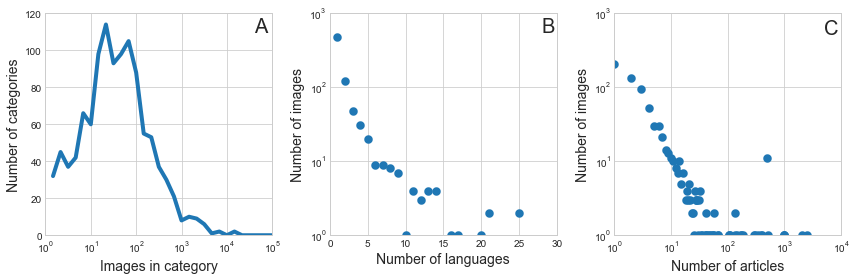

In [20]:
# Start figure
f,axs = plt.subplots(1,3,figsize=(12,4))

# Left figure
hist1_s.plot(lw=4,logx=True,ax=axs[0])
axs[0].set_xlim((1e0,1e5))
#axs[0].set_xscale('log')
axs[0].set_ylim((0,120))

axs[0].set_xlabel('Images in category',fontsize=14)
axs[0].set_ylabel('Number of categories',fontsize=14)
axs[0].text(x=4e4,y=110,s='A',fontsize=20)

# Center figure
hist2_s.reset_index().plot(kind='scatter',x='index',y=0,lw=4,logy=True,ax=axs[1])
axs[1].set_xlim((0,30))
axs[1].set_ylim((1e0,1e3))
axs[1].set_xlabel('Number of languages',fontsize=14)
axs[1].set_ylabel('Number of images',fontsize=14)
axs[1].text(x=28,y=5.5e2,s='B',fontsize=20)

# Center figure
hist3_s.reset_index().plot(kind='scatter',x='index',y=0,lw=4,logx=True,logy=True,ax=axs[2])
axs[2].set_xlim((1e0,1e4))
axs[2].set_ylim((1e0,1e3))
axs[2].set_xlabel('Number of articles',fontsize=14)
axs[2].set_ylabel('Number of images',fontsize=14)
axs[2].text(x=5e3,y=5.25e2,s='C',fontsize=20)

#
plt.tight_layout()
plt.savefig('category_file_members.pdf',bbox_inches='tight')

In [21]:
unique_images_in_categories = len(set([m for cat, members in commons_category_file_members_dict.items() for m in members]))
unique_categories = len(commons_category_file_members_dict)

print("There are {0:,} unique images in {1:,} categories".format(unique_images_in_categories,unique_categories))

There are 149,038 unique images in 1,112 categories


## Image usage

In [22]:
with open('all_coups_file_image_usage.json','r') as f:
    all_coups_image_usage = json.load(f)

In [23]:
topic_lang_image_counts_d = {}

for topic, topic_d in all_coups_image_usage.items():
    topic_lang_image_counts_d[topic] = {}
    for lang, lang_d in topic_d.items():
        topic_lang_image_counts_d[topic][lang] = len(lang_d)

topic_lang_image_counts_df = pd.DataFrame(topic_lang_image_counts_d).stack().reset_index()
topic_lang_image_counts_df.columns = ['lang','topic','image count']
topic_lang_image_counts_df.sort_values(['topic','lang']).head()

,lang,topic,image count
2,ar,17 July Revolution,0.0
75,bn,17 July Revolution,0.0
187,en,17 July Revolution,0.0
367,es,17 July Revolution,0.0
635,ja,17 July Revolution,0.0


In [24]:
all_coups_image_usage["2013 Egyptian coup d'état"]['en']

{'File:Anti Morsi protest march at 28th June 2013.jpg': ['Mohamed Morsi',
  "2013 Egyptian coup d'état",
  'June 2013 Egyptian protests'],
 'File:Damietta protests.jpg': ["2013 Egyptian coup d'état",
  'Post-coup unrest in Egypt (2013–2014)'],
 'File:Dead bodies in RABIA Massacre (3).jpg': ["2013 Egyptian coup d'état"],
 'File:General Al Sisi.jpg': ['Egypt', "2013 Egyptian coup d'état"],
 'File:Morsi supporter after mass killings of 27-July-2013.jpg': ["2013 Egyptian coup d'état"],
 'File:Secretary of Defense Chuck Hagel meets with Egyptian President Mohamed Morsy in Cairo, Egypt, April 24, 2013.jpg': ['Chuck Hagel',
  'Mohamed Morsi',
  "2013 Egyptian coup d'état"],
 'File:Soldier in Tahrir.jpg': ['Egyptian revolution of 2011',
  'Egyptian crisis (2011–14)',
  'Timeline of the Egyptian Crisis under the Supreme Council of the Armed Forces',
  'Sinai insurgency',
  '2012–13 Egyptian protests',
  "2013 Egyptian coup d'état",
  'June 2013 Egyptian protests',
  'Post-coup unrest in Egypt (

In [25]:
no_image_articles = []

for topic, topic_d in all_coups_image_usage.items():
    for lang, lang_d in topic_d.items():
        if len(lang_d) == 0:
            no_image_articles.append((topic,lang))
            
print("There are {0:,} multi-lingual articles containing no images".format(len(no_image_articles)))

There are 537 multi-lingual articles containing no images


In [26]:
no_image_any_lang = []
for (topic,lang1) in no_image_articles:
    image_sum = sum(len(lang_d) for lang2, lang_d in all_coups_image_usage[topic].items())
    if image_sum == 0 and topic not in no_image_any_lang:
        no_image_any_lang.append(topic)

print("There are {0:,} seed topics where no language edition has an image".format(len(no_image_any_lang)))

There are 71 seed topics where no language edition has an image


In [27]:
all_coups_image_usage["November 1966 Burundian coup d'état"]

{'en': {}, 'fr': {}, 'pt': {}}

In [28]:
alternative_images = {}
for (topic,lang1) in no_image_articles:
    if any(len(lang_d) == 0 for lang2, lang_d in all_coups_image_usage[topic].items()):
        for lang2, lang_d in all_coups_image_usage[topic].items():
            if len(lang_d) > 0:
                alternative_images[topic] = [file.split(':')[1] for file, file_list in lang_d.items()]
            
len(alternative_images)

79

In [29]:
pd.Series({k:len(set(v)) for k,v in alternative_images.items()}).max()

7

## Category network

In [30]:
with open('image_category_memberships.json','r') as f:
    image_category_memberships = json.load(f)

In [31]:
image_category_memberships['en']['File:Nasser Qaddafi Atassi 1969.jpg']

[{'Category:1969 in Libya': '2013-09-17T15:56:45Z'},
 {'Category:Arab nationalists': '2010-03-13T21:23:03Z'},
 {'Category:Gamal Abdel Nasser with Arab leaders': '2013-07-30T23:54:04Z'},
 {'Category:Muammar Gaddafi and Gamal Abdel Nasser': '2013-06-20T22:24:01Z'},
 {'Category:Muammar Gaddafi with national leaders': '2011-10-20T16:37:21Z'},
 {'Category:Nureddin al-Atassi': '2010-03-23T19:45:54Z'},
 {'Category:Relations of Egypt and Syria': '2013-11-02T22:58:06Z'},
 {'Category:Relations of Libya and Syria': '2013-11-02T22:58:06Z'}]

In [32]:
simple_l = []

for lang, lang_d in image_category_memberships.items():
    for file, cat_l in lang_d.items():
        for cat_d in cat_l:
            for cat_name, ts in cat_d.items():
                simple_l.append({'lang':lang,'file':file,'category':cat_name})

lang_cat_df = pd.DataFrame(simple_l)
lang_cat_gb = lang_cat_df.groupby(['category','lang']).agg({'file':len}).reset_index()
lang_cat_gb.rename(columns={'file':'weight'},inplace=True)
lang_cat_gb.sort_values('weight',ascending=False).head()

,category,lang,weight
268,Category:2006 coup d'état in Thailand,en,15
300,Category:2009 coup d'état in Honduras,pl,7
215,Category:1991 coup d'état attempt in the Sovie...,no,6
272,Category:2006 coup d'état in Thailand,gl,5
2856,Category:Revolução dos Cravos,pt,5


In [33]:
lang_cat_langs = lang_cat_gb['lang'].unique()
lang_cat_cats = lang_cat_gb['category'].unique()
lang_cat_g = nx.from_pandas_dataframe(source='lang',target='category',edge_attr=['weight'],df=lang_cat_gb)

print("There are {0:,} languages, {1:,} categories, and {2:,} edges in the network".format(len(lang_cat_langs),
                                                                                      len(lang_cat_cats),
                                                                                      lang_cat_g.number_of_edges()))

for lang in lang_cat_langs:
    lang_cat_g.add_node(lang,kind='language')
    
for cat in lang_cat_cats:
    lang_cat_g.add_node(cat,kind='category')

nx.write_gexf(lang_cat_g,'lang_cat_bipartite.gexf')

AttributeError: module 'networkx' has no attribute 'from_pandas_dataframe'

In [ ]:
proj_lang_cat_g = nx.bipartite.weighted_projected_graph(lang_cat_g.to_undirected(),lang_cat_langs)

print("There are {0:,} nodes and {1:,} edges in the network".format(proj_lang_cat_g.number_of_nodes(),
                                                                    proj_lang_cat_g.number_of_edges()))

In [ ]:
proj_lang_cat_g.edges(data=True)[:5]

In [ ]:
_s = lang_cat_df.groupby('lang').agg({'file':len})['file']
_s.sort_values(ascending=False)

## Tag network

In [ ]:
cols = ['IT-Active Image', 'IT-Passive Image',
        'D-Adult Male', 'D-Adult Female', 'D-Child Male', 'D-Child Female', 'D-Non-human', 
        'FE-Frown', 'FE-Smile', 
        'FPI-Foriegn Leaders', 'FPI-Foriegn Symbols',
        'GT-Alleged Atrocities', 'GT-Buildings', 'GT-Celebration', 'GT-Protest/Demonstration', 'GT-Destruction', 'GT-Diplomatic and Other Official Actions', 'GT-Documents/Communications', 'GT-Humanitarian Aid', 'GT-Locations/Maps/Infographics', 'GT-Memorials', 'GT-Military Actions', 'GT-Military Technology and Weaponry', 'GT-POWs', 'GT-Policing', 'GT-Portrait', 'GT-Signs/Symbols', 'GT-Suffering',
        'IF-Individual', 'IF-Group', 'IF-Individual in Relation to the Group', 'IF-Non-human',
        'TOP-Civilians', 'TOP-Journalists', 'TOP-Military or Political Leaders', 'TOP-Military Personnel', 'TOP-Police',
        'VI-Non-violent Image', 'VI-Violent Image']

In [ ]:
#filedir = 'E:/Dropbox/Workspace/Wikipedia images/'
filedir = '/Users/briankeegan/Dropbox/Workspace/Wikipedia images/'

jon_b0_df = pd.read_excel(filedir + 'XLS Batches/Coup_Project Jon.xls', sheetname='Sheet1')
jon_b1_df = pd.read_excel(filedir + 'XLS Batches/Coup_Project Batch 1.xls', sheetname='Sheet1')
jon_b2_df = pd.read_excel(filedir + 'XLS Batches/Coup_Project Batch 2.xls', sheetname='Sheet1')
jon_b3_df = pd.read_excel(filedir + 'XLS Batches/Coup_Project Batch 3.xls', sheetname='Sheet1')

all_jon_df = pd.concat([jon_b0_df,jon_b1_df,jon_b2_df,jon_b3_df],axis=1)
jon_cols = list(set(all_jon_df.columns))
all_jon_df = all_jon_df.loc[cols,jon_cols]

print(len(all_jon_df.columns))

In [ ]:
image_tags_dict = all_jon_df.T.to_dict('index')
with open('image_tags.json','w') as f:
    json.dump(image_tags_dict,f,cls=MyEncoder)

In [ ]:
tag_file_el = all_jon_df.unstack().reset_index()
tag_file_el.rename(columns={'level_0':'file','level_1':'tag',0:'tie'},inplace=True)
tag_file_el = tag_file_el[tag_file_el['tie'] > 0].reset_index(drop=True)

tag_file_files = tag_file_el['file'].unique()
tag_file_tags = tag_file_el['tag'].unique()

file_tag_g = nx.from_pandas_dataframe(source='file',target='tag',edge_attr=['tie'],df=tag_file_el)

print("There are {0:,} files, {1:,} tags, and {2:,} edges in the network".format(len(tag_file_files),
                                                                                 len(tag_file_tags),
                                                                                 file_tag_g.number_of_edges()))

for file in tag_file_files:
    file_tag_g.add_node(file,kind='file')
    
for tag in tag_file_tags:
    file_tag_g.add_node(tag,kind='tag')

nx.write_gexf(file_tag_g,'tag_file_bipartite.gexf')

## Language-tag similarity

In [ ]:
with open('image_tags.json','r') as f:
    image_tags_dict = json.load(f)
    
with open('topics_parent_lang.json','r') as f:
    topics_parent_lang_dict = json.load(f)
    
with open('all_coups_file_image_usage.json','r') as f:
    all_coups_image_usage = json.load(f)

# Keys are decomposed unicode strings, values are composed unicode strings
with open('tagged_scraped_disjoint_filenamesEmilyTag_match.json','r') as f:
    unicode_mapping_json = json.load(f)
    
unicode_mapping_json_rv = {v.encode('utf8'):k.encode('utf8') for k,v in unicode_mapping_json.items()}

In [ ]:
for k,v in list(image_tags_dict.items()):
    composed_k = unicodedata.normalize('NFKC',k).encode('utf8')
    image_tags_dict[composed_k] = v
    del image_tags_dict[k]

In [ ]:
'Marahoué'.encode('utf8') == unicodedata.normalize('NFKC','Marahoué').encode('utf8')

In [ ]:
list(unicode_mapping_json.items())[:5]

Get the names of all the images.

In [34]:
all_image_filenames = list(set(os.listdir('/Users/briankeegan/Dropbox/Workspace/Wikipedia images/Images/')) | set(os.listdir('/Users/briankeegan/Dropbox/Workspace/Wikipedia images/Error Images/')))
all_image_filenames = [unicodedata.normalize('NFKC',i) for i in all_image_filenames]

print("There are {0:,} images downloaded to disk we can use for coding".format(len(all_image_filenames)))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/briankeegan/Dropbox/Workspace/Wikipedia images/Images/'

In [35]:
set(all_image_filenames) - set(image_tags_dict.keys())

NameError: name 'all_image_filenames' is not defined

We want to align the `image_tags_dict` and files in `lang_images`, but there are Unicode normalization issues that happened when writing the filenames to disk as compared to how they're encoded on Wikipedia. It appears that writing to disk decomposed into characters and modifiers and Wikipedia has the composed representation.

See also:
* https://stackoverflow.com/questions/14682397/can-somone-explain-how-unicodedata-normalizeform-unistr-work-with-examples
* https://docs.python.org/2/library/unicodedata.html#unicodedata.normalize

In [36]:
'4.19 혁명.jpg'.encode('utf8'), '4.19 혁명.jpg'.encode('utf8'), unicodedata.normalize('NFKC','4.19 혁명.jpg').encode('utf8')

(b'4.19 \xed\x98\x81\xeb\xaa\x85.jpg',
 b'4.19 \xe1\x84\x92\xe1\x85\xa7\xe1\x86\xa8\xe1\x84\x86\xe1\x85\xa7\xe1\x86\xbc.jpg',
 b'4.19 \xed\x98\x81\xeb\xaa\x85.jpg')

In [37]:
list(image_tags_dict.keys())[0].decode('utf8')

NameError: name 'image_tags_dict' is not defined

In [38]:
#for image,tag_dict in list(image_tags_dict.items()):
#    if image in unicode_mapping_json_rv.keys():
#        new_image = unicode_mapping_json_rv[image]
#        image_tags_dict[new_image] = image_tags_dict[image]
#        del image_tags_dict[image]

for image,tag_dict in list(image_tags_dict.items()):
    image_decoded = image.decode('utf8')
    new_image_name = unicodedata.normalize('NFKC',image_decoded)
    if new_image_name in unicode_mapping_json_rv.keys():
        new_image_name = new_image_name.replace('_',' ')
        image_tags_dict[new_image_name] = image_tags_dict[image_decoded]

        del image_tags_dict[image_decoded]

In [39]:
lang_images = {lang:[] for topic, topic_d in all_coups_image_usage.items() for lang, lang_d in topic_d.items() if len(lang_d) > 0}

for topic, topic_d in all_coups_image_usage.items():
    for lang, lang_d in topic_d.items():
        for file, filelist in lang_d.items():
            lang_images[lang].append(file.split(':')[1])

These are images that were downloaded and tagged but apparently don't appear in any languages.

In [40]:
set(image_tags_dict.keys()) - set([f for lang,files in lang_images.items() for f in files])

{b'"De Historische Strijd" Herdenkingsmonument revolutie 25 februari 1980 - Nieuw-Amsterdam - 20418126 - RCE.jpg',
 b'-De_Historische_Strijd-_Herdenkingsmonument_revolutie_25_februari_1980_-_Nieuw-Amsterdam_-_20418127_-_RCE.jpg',
 b'11 septiembre 1976- manifestacion pro Pinochet.jpg',
 b'14 July revolution - mutilated corpse.jpg',
 b'15 July-Erdo\xc4\x9fan SMS.jpg',
 b'15 Temmuz \xc5\x9eehitler Park\xc4\xb1 tabelas\xc4\xb1.jpg',
 b'1920UnitedFruitCompanyEntrance.jpg',
 b"1962 Burmese coup d'\xc3\xa9tat.jpg",
 b"1962 Burmese coup d'\xc3\xa9tat2.jpg",
 b'1973Babadinca0048.jpg',
 b'1989 December 16. sug\xc3\xa1r\xc3\xbat \xc3\xa9s a Tudor Vladimirescu \xc3\xbat keresztez\xc5\x91d\xc3\xa9se. Fortepan 31892.jpg',
 b'1989 Iliescu television.jpg',
 b'1991 CPA 6367.jpg',
 b'1991 CPA 6368.jpg',
 b'1991 CPA 6369.jpg',
 b'1991 CPA 6370.jpg',
 b'1991 coup attempt1.jpg',
 b'1991 coup attempt4.jpg',
 b'1991 coup attempt5.jpg',
 b'1991-August-Moscow.jpg',
 b'1991-Barrikad-BelyDom.jpg',
 b'1991_coup_y

In [41]:
set([unicodedata.normalize('NFKC',f).replace('_',' ') for lang,files in lang_images.items() for f in files]) - set(image_tags_dict.keys())

{'"De Historische Strijd" Herdenkingsmonument revolutie 25 februari 1980 - Nieuw-Amsterdam - 20418126 - RCE.jpg',
 '1 Turkish lira-Deads in 15 July.jpg',
 '11 septiembre 1976- manifestacion pro Pinochet.jpg',
 '14 July revolution - mutilated corpse.jpg',
 '15 July-Erdoğan SMS.jpg',
 '15 Temmuz Şehitler Parkı tabelası.jpg',
 '1920UnitedFruitCompanyEntrance.jpg',
 "1962 Burmese coup d'état.jpg",
 "1962 Burmese coup d'état2.jpg",
 '1973Babadinca0048.jpg',
 '1989 December 16. sugárút és a Tudor Vladimirescu út kereszteződése. Fortepan 31892.jpg',
 '1989 Iliescu television.jpg',
 '1991 CPA 6367.jpg',
 '1991 CPA 6368.jpg',
 '1991 CPA 6369.jpg',
 '1991 CPA 6370.jpg',
 '1991 coup attempt1.jpg',
 '1991 coup attempt4.jpg',
 '1991 coup attempt5.jpg',
 '1991 coup yeltsin.jpg',
 '1991-August-Moscow.jpg',
 '1991-Barrikad-BelyDom.jpg',
 "1992 Venezuelan coup d'état attempts Hugo Chávez speech.jpg",
 "1992 Venezuelan coup d'état attempts Miraflores.jpg",
 "1992 Venezuelan coup d'état attempts collage.

In [42]:
len(list(set(image_tags_dict.keys()))), len(list(set([f for lang,files in lang_images.items() for f in files])))

(774, 747)

## Revision network

In [253]:
lang_user_rev_edgelist.head()

,lang,user,revid
0,af,Aliwal2012,7
1,af,Wwikix,1
2,am,109.151.136.89,1
3,am,Addbot,1
4,am,Bulgew1,23


In [322]:
lang_user_rev_edgelist = rev_df.groupby(['lang','user']).agg({'revid':pd.Series.nunique}).reset_index()
lang_user_rev_g = nx.from_pandas_dataframe(lang_user_rev_edgelist,source='user',target='lang',edge_attr=True)

for lang in lang_user_rev_edgelist['lang'].unique():
    lang_user_rev_g.add_node(lang,kind='lang')

for lang in lang_user_rev_edgelist['user'].unique():
    lang_user_rev_g.add_node(lang,kind='user')

print("There are {0:,} languages, {1:,} users, and {2:,} edges in the network".format(len(lang_user_rev_edgelist['lang'].unique()),
                                                                                      len(lang_user_rev_edgelist['user'].unique()),
                                                                                      lang_user_rev_g.number_of_edges()))

nx.write_gexf(lang_user_rev_g,'lang_user_revisions.gexf')

There are 97 languages, 21,657 users, and 24,319 edges in the network


In [302]:
rev_langs = list(lang_user_rev_edgelist['lang'].unique())
proj_lang_rev_g = nx.bipartite.weighted_projected_graph(lang_user_rev_g.to_undirected(),nodes=rev_langs)

print("There are {0:,} nodes and {1:,} edges in the network".format(proj_lang_rev_g.number_of_nodes(),
                                                                    proj_lang_rev_g.number_of_edges()))

There are 97 nodes and 2,855 edges in the network


## Image usage

In [99]:
with open('all_coups_file_image_usage.json','r') as f:
    all_coups_image_usage = json.load(f)

In [34]:
lang_topic_df = pd.DataFrame({article:{lang:len(lang_d) for lang,lang_d in d.items()} for article,d in all_coups_image_usage.items()}).T
#lang_topic_df = lang_topic_df.fillna(0)
lang_topic_df.mean().sort_values(ascending=False).head()


cv     7.000000
arz    4.000000
mn     4.000000
gl     2.833333
ar     2.536585
dtype: float64

In [121]:
all_coups_image_usage["17 July Revolution"]

{'ar': {},
 'bn': {},
 'en': {},
 'es': {},
 'ja': {},
 'pl': {'Ahmad Hassan el Bakr.jpg': ['Premierzy Iraku',
   'Ahmad Hasan al-Bakr',
   'Partia Baas (Irak)',
   'Zamach stanu w Iraku (1968)']},
 'pt': {},
 'zh': {}}

In [248]:
full_image_list = list()
for article, article_payload in all_coups_image_usage.items():
    for lang,file_payload in article_payload.items():
        for filename,pagelist in file_payload.items():
            if filename not in full_image_list:
                full_image_list.append(filename)
                
print("There are {0} images in the full_image_list".format(len(full_image_list)))

full_image_list[:5]

There are 739 images in the full_image_list


['Project 571 Outline.jpg',
 'President Abd al-Salam Arif.jpg',
 'Maflaq.jpg',
 'Ahmad Hassan el Bakr.jpg',
 'Abdul-salam-arif.jpg']

### Image-language network

In [ ]:
image_lang_g = nx.DiGraph()

for topic, topic_d in all_coups_image_usage.items():
    for lang, file_d in topic_d.items():
        for filename, pagelist in file_d.items():
            f = filename.split(':')[1]
            image_lang_g.add_edge(f, lang)
            image_lang_g.add_node(f, kind='file')
            image_lang_g.add_node(lang, kind='lang')

### Image-page network

In [158]:
image_page_usage_g = nx.DiGraph()
for topic, topic_d in all_coups_image_usage.items():
    for lang, file_d  in topic_d.items():
        for filename, pagelist in file_d.items():
            if len(pagelist) < 10:
                for page in pagelist:
                    image_page_usage_g.add_node(page,lang=lang,kind='article')
                    image_page_usage_g.add_node(filename,lang='image',kind='image')
                    image_page_usage_g.add_edge(page,filename)

print("There are {0:,} nodes and {1:,} edges in the network".format(image_page_usage_g.number_of_nodes(),image_page_usage_g.number_of_edges()))
nx.write_gexf(image_page_usage_g,'image_page_usage_g.gexf')

There are 2,464 nodes and 2,884 edges in the network


### Image-language network

In [45]:
image_lang_g = nx.DiGraph()
for topic, topic_d in all_coups_image_usage.items():
    for lang, file_d  in topic_d.items():
        for filename, pagelist in file_d.items():
            if len(pagelist) < 10:
                f = filename.split(':')[1]
                image_lang_g.add_node(f,kind='image')
                image_lang_g.add_node(lang,kind='lang')
                if image_lang_g.has_edge(f,lang):
                    image_lang_g[lang][f]['weight'] += 1
                else:
                    image_lang_g.add_edge(lang,f,weight=1)

image_lang_langs = [n for n,d in image_lang_g.nodes(data=True) if d['kind'] == 'lang']
image_lang_images = [n for n,d in image_lang_g.nodes(data=True) if d['kind'] == 'image']

print("There are {0:,} languages, {1:,} images, and {2:,} edges in the network".format(len(image_lang_langs),
                                                                                       len(image_lang_images),
                                                                                       image_lang_g.number_of_edges()))
nx.write_gexf(image_lang_g,'image_lang_usage.gexf')

There are 77 languages, 686 images, and 1,531 edges in the network


In [177]:
image_lang_usage_langs = [n for n,d in image_lang_usage_g.nodes(data=True) if d['kind'] == 'lang']
clustering = nx.bipartite.clustering(image_lang_usage_g.to_undirected(),nodes=image_lang_usage_langs,mode='dot')
pd.Series(clustering).sort_values(ascending=False).head()

oc          0.258333
be-x-old    0.258197
is          0.120494
azb         0.120494
lb          0.104938
dtype: float64

In [187]:
proj_image_lang_usage_g = nx.bipartite.weighted_projected_graph(image_lang_usage_g.to_undirected(),nodes=image_lang_usage_langs)
weight_1_edges = [(i,j) for i,j,d in proj_image_lang_usage_g.edges(data=True) if d['weight'] > 1]
#proj_image_lang_usage_g.remove_edges_from(weight_1_edges)
pd.Series(nx.degree_centrality(proj_image_lang_usage_g)).sort_values(ascending=False)

es          0.868421
he          0.776316
de          0.763158
pt          0.736842
en          0.736842
zh          0.736842
ja          0.736842
ar          0.723684
tr          0.671053
no          0.657895
fr          0.657895
pl          0.644737
ca          0.644737
ro          0.644737
th          0.644737
ko          0.644737
gl          0.631579
ru          0.618421
sr          0.618421
fi          0.605263
it          0.605263
hr          0.592105
nl          0.592105
vi          0.592105
bg          0.578947
sv          0.578947
id          0.565789
el          0.552632
cs          0.552632
ka          0.539474
              ...   
lb          0.263158
si          0.263158
sco         0.250000
mk          0.236842
bn          0.236842
sk          0.210526
sq          0.197368
ku          0.197368
cv          0.184211
arz         0.184211
ga          0.171053
lt          0.157895
is          0.144737
azb         0.144737
simple      0.144737
zh-yue      0.131579
br          0

### Image-lang-tag tripartite network

In [9]:
tag_d = tag_file_el.groupby('file').agg({'tag':lambda x:list(x)})['tag'].to_dict()
tag_d

{'"De Historische Strijd" Herdenkingsmonument revolutie 25 februari 1980 - Nieuw-Amsterdam - 20418126 - RCE.jpg': ['IT-Passive Image',
  'D-Non-human',
  'GT-Memorials',
  'IF-Non-human',
  'VI-Non-violent Image'],
 '-De_Historische_Strijd-_Herdenkingsmonument_revolutie_25_februari_1980_-_Nieuw-Amsterdam_-_20418127_-_RCE.jpg': ['IT-Passive Image',
  'D-Non-human',
  'GT-Memorials',
  'IF-Non-human',
  'VI-Non-violent Image'],
 '11 septiembre 1976- manifestacion pro Pinochet.jpg': ['IT-Active Image',
  'D-Adult Male',
  'D-Adult Female',
  'FE-Smile',
  'GT-Celebration',
  'IF-Group',
  'TOP-Civilians',
  'VI-Non-violent Image'],
 '14 July revolution - mutilated corpse.jpg': ['IT-Active Image',
  'D-Adult Male',
  'FE-Frown',
  'GT-Alleged Atrocities',
  'IF-Individual',
  'IF-Individual in Relation to the Group',
  'TOP-Civilians',
  'VI-Violent Image'],
 '15 July-Erdoğan SMS.jpg': ['IT-Passive Image',
  'D-Non-human',
  'GT-Documents/Communications',
  'VI-Non-violent Image'],
 '15 T

In [8]:
filenames = []
for topic, topic_d in all_coups_image_usage.items():
    for lang, file_d  in topic_d.items():
        for filename, pagelist in file_d.items():
            if len(pagelist) < 10:
                f = filename.split(':')
                if any(e in f[0] for e in ['.png','.jpg']):
                    filenames.append(f[0])
                else:
                    filenames.append(f[1])
len(set(filenames))

686

In [23]:
egypt_tp_g = nx.DiGraph()

for lang, lang_d in all_coups_image_usage["2013 Egyptian coup d'état"].items():
    for file, file_l in lang_d.items():
        f = file.split(':')[1]
        egypt_tp_g.add_edge(lang,f,kind='lang-file')
        egypt_tp_g.add_node(lang,kind='lang')
        egypt_tp_g.add_node(f,kind='file')
        try:
            for tag in tag_d[f]:
                egypt_tp_g.add_edge(tag,f,kind="tag-file")
                egypt_tp_g.add_node(tag,kind='tag')
        except KeyError:
            print("No tag for {0}".format(f))
            pass

egypt_tp_tags = [n for n,d in egypt_tp_g.nodes(data=True) if d['kind'] == 'tag']
egypt_tp_langs = [n for n,d in egypt_tp_g.nodes(data=True) if d['kind'] == 'lang']
egypt_tp_files = [n for n,d in egypt_tp_g.nodes(data=True) if d['kind'] == 'file']

print("""There are {0:,} tags, {1:,} languages, {2:,} files, and {3:,} edges in the network
""".format(len(egypt_tp_tags),
           len(egypt_tp_langs),
           len(egypt_tp_files),
           egypt_tp_g.number_of_edges()))

nx.write_gexf(egypt_tp_g,'egypt_tripartite.gexf')

No tag for General el Sisi Mursiyi görevden alındığını açıklarken.png
No tag for FJP.png
No tag for General Al-Sisi, announcing the removal of President Morsi.png
No tag for General Al-Sisi, announcing the removal of President Morsi.png
No tag for حزب النور.png
No tag for حزب الحرية والعدالة.png
No tag for Freedom and Justice Party (Egypt).jpg
There are 30 tags, 25 languages, 40 files, and 303 edges in the network



In [24]:
soviet_tp_g = nx.DiGraph()

for lang, lang_d in all_coups_image_usage["1991 Soviet coup d'état attempt"].items():
    for file, file_l in lang_d.items():
        f = file.split(':')[1]
        soviet_tp_g.add_edge(lang,f,kind='lang-file')
        soviet_tp_g.add_node(lang,kind='lang')
        soviet_tp_g.add_node(f,kind='file')
        try:
            for tag in tag_d[f]:
                soviet_tp_g.add_edge(tag,f,kind="tag-file")
                soviet_tp_g.add_node(tag,kind='tag')
        except KeyError:
            print("No tag for {0}".format(f))
            pass

soviet_tp_tags = [n for n,d in soviet_tp_g.nodes(data=True) if d['kind'] == 'tag']
soviet_tp_langs = [n for n,d in soviet_tp_g.nodes(data=True) if d['kind'] == 'lang']
soviet_tp_files = [n for n,d in soviet_tp_g.nodes(data=True) if d['kind'] == 'file']

print("""There are {0:,} tags, {1:,} languages, {2:,} files, and {3:,} edges in the network
""".format(len(soviet_tp_tags),
           len(soviet_tp_langs),
           len(soviet_tp_files),
           soviet_tp_g.number_of_edges()))

nx.write_gexf(soviet_tp_g,'soviet_tripartite.gexf')

No tag for Кокарда рядового и сержантского состава Советской Армии.jpg
No tag for 1991 coup yeltsin.jpg
No tag for Dzerzhinsky Statue, which once dominated Lyubianka Square.jpg
No tag for 1991 coup yeltsin.jpg
No tag for P Russia.png
No tag for Logo for Liberal Democratic Party of Russia.png
No tag for Logo for Liberal Democratic Party of Russia.png
No tag for File
No tag for Logo for Liberal Democratic Party of Russia.png
No tag for 24 жніўня 1991.jpg
No tag for LRAP un MP 1991. gada 19. augusta paziņojums.jpg
No tag for PSRS Valsts padomes lēmums par Latvijas Republikas neatkarības atzīšanu.jpg
No tag for Konstitucionālais likums Par Latvijas Republikas valstisko statusu.jpg
There are 30 tags, 35 languages, 42 files, and 358 edges in the network



In [30]:
tag_d['Konstitucionālais_likums_Par_Latvijas_Republikas_valstisko_statusu.jpg']

['IT-Passive Image',
 'D-Non-human',
 'GT-Documents/Communications',
 'IF-Non-human',
 'VI-Non-violent Image']

### Image-lang-tag after all the unicode non-sense

In [47]:
all_coups_image_usage['1991 Soviet coup d\'état attempt']['en']

{'File:1991 coup attempt1.jpg': ['1991',
  'Cold War',
  "1991 Soviet coup d'état attempt",
  'Dissolution of the Soviet Union'],
 'File:1991 coup attempt4.jpg': ['T-80', "1991 Soviet coup d'état attempt"],
 'File:Boris Yeltsin 19 August 1991-1.jpg': ['Russia',
  'Soviet Union',
  'White House (Moscow)',
  "1991 Soviet coup d'état attempt",
  'Alexander Korzhakov',
  'Civil resistance',
  'Boris Yeltsin',
  'Dissolution of the Soviet Union'],
 'File:Bush Gorba P15623-25A.jpg': ['George H. W. Bush',
  'Cold War',
  "1991 Soviet coup d'état attempt",
  'Presidency of George H. W. Bush',
  'List of Soviet Union–United States summits'],
 'File:Logo for Liberal Democratic Party of Russia.png': ["1991 Soviet coup d'état attempt"]}

In [71]:
with open('image_tags.json','r') as f:
    tag_d = json.load(f)
    
for file,label_d in list(tag_d.items()):
    concated_file = unicodedata.normalize('NFKC',file)#.encode('utf8')
    tag_d[concated_file] = label_d
    #del tag_d[file]

In [72]:
len(tag_d)

890

In [64]:
unicodedata.normalize('NFKC','Ülkü Ocakları Eğitim ve Kültür Vakfı Logosu.png')#.encode('utf8')

'Ülkü Ocakları Eğitim ve Kültür Vakfı Logosu.png'

In [53]:
tag_d.keys()

dict_keys(['PozeRevolutia1989clujByRazvanRotta13.jpg', 'Mengistu_and_germame_Neway.jpg', "Hashem al Atta, 1971 Sudanese coup d'état.jpg", 'Pinochet en 1974.jpg', 'T-72 tank in Moscow, August 1991.jpg', 'Necmettin Erbakan.jpg', 'Ülkü Ocakları Eğitim ve Kültür Vakfı Logosu.png', 'Truman initiating Korean involvement.jpg', 'Gloria Macapagal-Arroyo, Davos.jpg', 'Nuamthong.jpg', 'RichardNixon.jpg', '2014 Suchum, Siedziba rządu i prezydenta Republiki Abchazji (04).jpg', 'Juntagovernativa1969.png', '1989 Iliescu television.jpg', 'Shaabanbimokh.jpg', 'Grave of Nicolae Ceausescu - Ghencea Civil Cemetery - Bucharest - Romania.jpg', 'HosseinFatemi2.jpg', 'Nasser, al-Bakr and Atassi, 1963.jpg', 'General Hafez al-Assad in 1970, during the Syrian Corrective Revolution.jpg', 'John L Throckmorton.jpg', 'NF 1978 - 1980.jpg', 'Tandja in Nigeria June 2007.jpg', 'Ayatmohagheghi.jpg', 'Boris Yeltsin 1993.jpg', 'Otelo.jpg', 'Order of the Red Banner.png', 'Bakkir.jpg', 'Madame Ngô Đình Nhu and Lyndo

In [75]:
all_coup_g = nx.DiGraph()

for coup, coup_d in all_coups_image_usage.items():
    for lang, lang_d in coup_d.items():
        for file, file_l in lang_d.items():
            f = file.split(':')[1]
            all_coup_g.add_edge(lang,f,kind='lang-file')
            all_coup_g.add_node(lang,kind='lang')
            all_coup_g.add_node(f,kind='file')
            try:
                for tag in tag_d[f]:
                    all_coup_g.add_edge(tag,f,kind="tag-file")
                    all_coup_g.add_node(tag,kind='tag')
            except KeyError:
                print("No tag for {0}".format(f))
                pass

all_coup_tags = [n for n,d in all_coup_g.nodes(data=True) if d['kind'] == 'tag']
all_coup_langs = [n for n,d in all_coup_g.nodes(data=True) if d['kind'] == 'lang']
all_coup_files = [n for n,d in all_coup_g.nodes(data=True) if d['kind'] == 'file']

print("""There are {0:,} tags, {1:,} languages, {2:,} files, and {3:,} edges in the network
""".format(len(all_coup_tags),
           len(all_coup_langs),
           len(all_coup_files),
           all_coup_g.number_of_edges()))

nx.write_gexf(all_coup_g,'all_coups.gexf')

No tag for Bakr.jpg
No tag for Aref abderazak.jpg
No tag for Last day qasim.jpg
No tag for Taher yahya.jpg
No tag for Казнь Касема.jpg
No tag for Burkinabé uprising at Place de la Nation.jpg
No tag for The Bangkok Post, September 20, 2006.jpg
No tag for The nation 200506.jpg
No tag for King CDRM L.jpg
No tag for 21438 010.jpg
No tag for Plevne Marşı pul.jpg
No tag for 27 Mayıs Darbesi sembolü.png
No tag for Bundesarchiv Bild 183-55823-0005, Berlin, Karl-Marx-Allee, "Deutsche Sporthalle".jpg
No tag for Bundesarchiv Bild 183-55823-0005, Berlin, Karl-Marx-Allee, "Deutsche Sporthalle".jpg
No tag for Bundesarchiv Bild 183-55823-0005, Berlin, Karl-Marx-Allee, "Deutsche Sporthalle".jpg
No tag for 1 Turkish lira-Deads in 15 July.jpg
No tag for Won Democracy Turkey.jpg
No tag for KYK 15 Temmuz sergisi.jpg
No tag for Maslak 15 July Occupy residential.jpg
No tag for مذيعة قناة تي آر تي.jpg
No tag for صورة دبابات الإنقلابيين العسكريين التركيين.jpg
No tag for صورة ذبابات الإنقلابيين العسكريين الترك

### Clustering

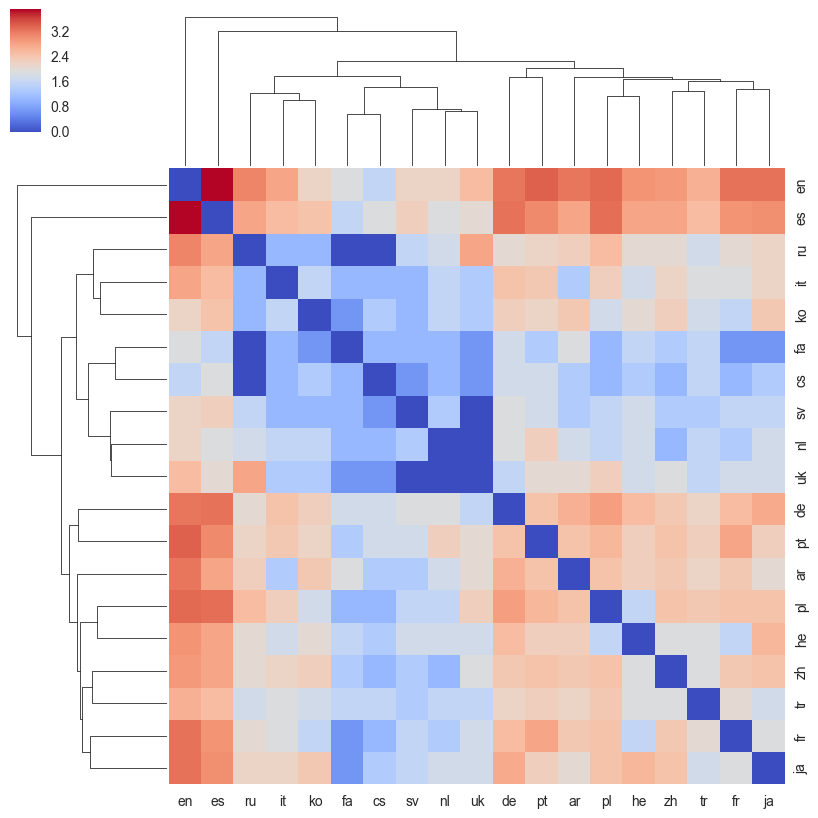

In [244]:
top_langs_proj_image_lang_usage_adj = np.log(nx.adj_matrix(proj_image_lang_usage_g,nodelist=top_languages).todense()+1)
top_languages = ['en','de','fr','ja','es','ru','it','zh','pt','pl','nl','uk','fa','he','ko','ar','sv','cs','tr']
top_langs_proj_image_lang_usage_df = pd.DataFrame(data=top_langs_proj_image_lang_usage_adj, index=top_languages, columns=top_languages)
sb.clustermap(top_langs_proj_image_lang_usage_df,cmap='coolwarm')
#plt.tight_layout()
plt.savefig('lang_image_similarity.pdf')

In [124]:
multiindexable_d = {}
for topic, topic_d in all_coups_image_usage.items():
    for lang, file_d  in topic_d.items():
        multiindexable_d[(topic, lang)] = len(file_d)

In [152]:
creation_year_s = rev_df.groupby(['parent_topic','lang']).agg({'year':np.min})['year']
creation_year_df = pd.DataFrame({'Year':creation_year_s,'Images':pd.Series(multiindexable_d)})
creation_year_df.reset_index(inplace=True)
creation_year_df.rename(columns={'level_0':'Topic','level_1':'Language'},inplace=True)
lang_subset_creation_year_df = creation_year_df[creation_year_df['Language'].isin(['en','de','fr','ja','es','ru','it','zh','pt','pl','nl','uk','fa','he','ko','ar','sv','cs','tr'])]

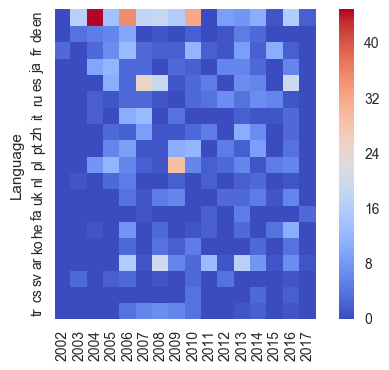

In [153]:
lang_subset_ct = pd.crosstab(index = lang_subset_creation_year_df['Language'],
                             columns = lang_subset_creation_year_df['Year'],
                             values = lang_subset_creation_year_df['Images'],
                             aggfunc = np.sum)
lang_subset_ct = lang_subset_ct.fillna(0).ix[['en','de','fr','ja','es','ru','it','zh','pt','pl','nl','uk','fa','he','ko','ar','sv','cs','tr']]
lang_subset_ct.columns = range(2002,2018)
sb.heatmap(lang_subset_ct,square=True,cmap='coolwarm')

## Interlanguage links

In [102]:
with open("all_coups_interlanguage_links.json",'r') as f:
    coup_interlanguage_links = json.load(f)

In [276]:
lang_link_g = nx.Graph()

for event, lang_d in coup_interlanguage_links.items():
    for lang1, link_d in lang_d.items():
        for link, langlink_d in link_d.items():
            for lang2, langlink in langlink_d.items():
                if lang_link_g.has_edge(lang1,lang2) and lang1 != lang2:
                    lang_link_g[lang1][lang2]['weight'] += 1
                elif lang1 != lang2:
                    lang_link_g.add_edge(lang1,lang2,weight=1)
                
print("There are {0:,} nodes and {1:,} edges in the network".format(lang_link_g.number_of_nodes(),lang_link_g.number_of_edges()))

There are 291 nodes and 20,939 edges in the network


In [277]:
lang_link_g.to_undirected().edge['et']['ceb']

{'weight': 79}

## External links

In [278]:
with open('all_coups_extlinks_usage.json','r') as f:
    external_links_usage = json.load(f)

In [284]:
lang_ext_link_g = nx.DiGraph()
language_list = []

for event, lang_d in external_links_usage.items():
    for lang, url_d in lang_d.items():
        language_list.append(lang)
        for url, count in url_d.items():
            if lang_ext_link_g.has_edge(lang,url):
                lang_ext_link_g[lang][url]['weight'] += count
            else:
                lang_ext_link_g.add_edge(lang,url,weight=count)
                
print("There are {0:,} nodes and {1:,} edges in the network".format(lang_ext_link_g.number_of_nodes(),lang_ext_link_g.number_of_edges()))

proj_lang_ext_link_g = nx.bipartite.weighted_projected_graph(lang_ext_link_g.to_undirected(),nodes=list(set(language_list)))
print("There are {0:,} nodes and {1:,} edges in the network".format(proj_lang_ext_link_g.number_of_nodes(),
                                                                    proj_lang_ext_link_g.number_of_edges()))

There are 2,867 nodes and 6,600 edges in the network
There are 81 nodes and 2,345 edges in the network


## Combine graphs

In [298]:
def to_pandas_edgelist(G):
    edges_d = G.edges(data=True)
    _df = pd.DataFrame(edges_d)
    _df[2] = _df[2].apply(lambda x:x['weight'])
    _df.rename(columns={0:'lang1',1:'lang2',2:'weight'},inplace=True)
    _df.set_index(['lang1','lang2'],inplace=True)
    return _df

In [318]:
ext_link_el_s = to_pandas_edgelist(proj_lang_ext_link_g)['weight']
iwiki_link_el_s = to_pandas_edgelist(lang_link_g)['weight']
image_usage_el_s = to_pandas_edgelist(proj_image_lang_usage_g)['weight']
editor_revs_el_s = to_pandas_edgelist(proj_lang_rev_g)['weight']

link_strength_df = pd.DataFrame({'External':ext_link_el_s,'Internal':iwiki_link_el_s,'Images':image_usage_el_s,'Editors':editor_revs_el_s})
link_strength_df.dropna(subset=['Images'],inplace=True)
link_strength_df.fillna(0,inplace=True)
link_strength_df.reset_index(inplace=True)
link_strength_df.to_csv('link_strength.csv',index=False)
print(len(link_strength_df))
link_strength_df.head()

1141


,lang1,lang2,Editors,External,Images,Internal
0,af,en,0.0,1.0,1.0,0.0
1,ar,da,20.0,12.0,2.0,912.0
2,ar,de,0.0,38.0,14.0,0.0
3,ar,eo,0.0,4.0,1.0,0.0
4,ar,es,31.0,48.0,16.0,3763.0


## Image tag clustering

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

#from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sn
from kmodes.kmodes import KModes
from sklearn.cluster import DBSCAN
from sklearn import metrics


In [7]:
# Read in file
image_tags_df = pd.read_excel('!image_tags.xls')

# Only include columns with "Code"
_cols = ['Title'] + [c for c in image_tags_df.columns if 'Code:' in c]
image_tags_df = image_tags_df[_cols]

# Exclude columns where there are no coded values
bad_cols = image_tags_df.sum()[image_tags_df.sum() == 0].index
image_tags_df = image_tags_df[[c for c in image_tags_df.columns if c not in bad_cols]]

# Only include tags where both coders agree
#image_tags_df = image_tags_df.replace({1:0}).replace({2:1})

# Rename columns
image_tags_df.columns = [c[6:] for c in image_tags_df.columns]

# Set index
image_tags_df.rename(columns={'':'image'},inplace=True)
image_tags_df.set_index('image',inplace=True)

len(image_tags_df)

766

In [17]:
# with open('image_tags.json','r') as f:
#     image_tags = json.load(f)
    
# image_tags_df = pd.DataFrame(image_tags).T
# image_tags_ri_df = image_tags_df.reset_index()
# len(image_tags_df)

774

In [5]:
image_tags_df.to_csv('!EP_tags_cleaned.csv',encoding='utf8')

## KMode


!!**Trial Number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 38, cost: 5097.0
Run 1, iteration: 2/100, moves: 0, cost: 5097.0
!!**Trial Number 3
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 87, cost: 4494.0
Run 1, iteration: 2/100, moves: 28, cost: 4494.0
!!**Trial Number 4
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 93, cost: 4366.0
Run 1, iteration: 2/100, moves: 10, cost: 4366.0
!!**Trial Number 5
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, 

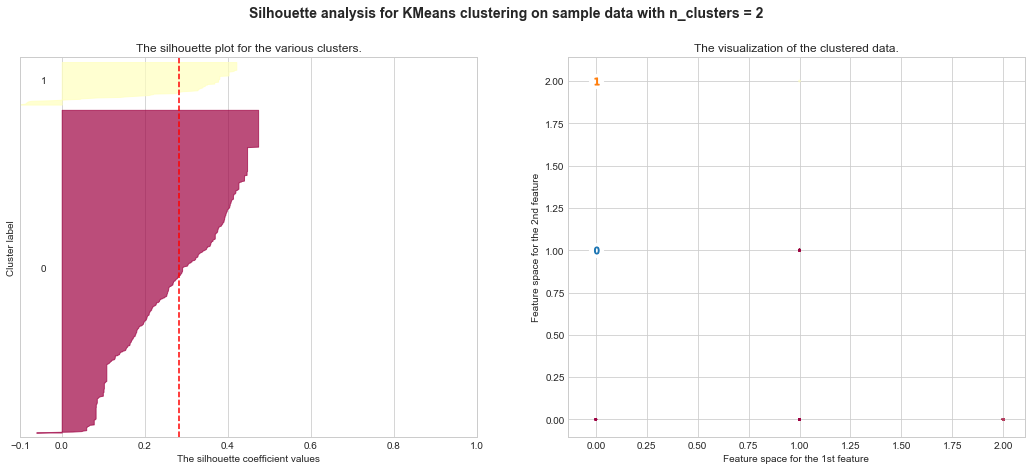

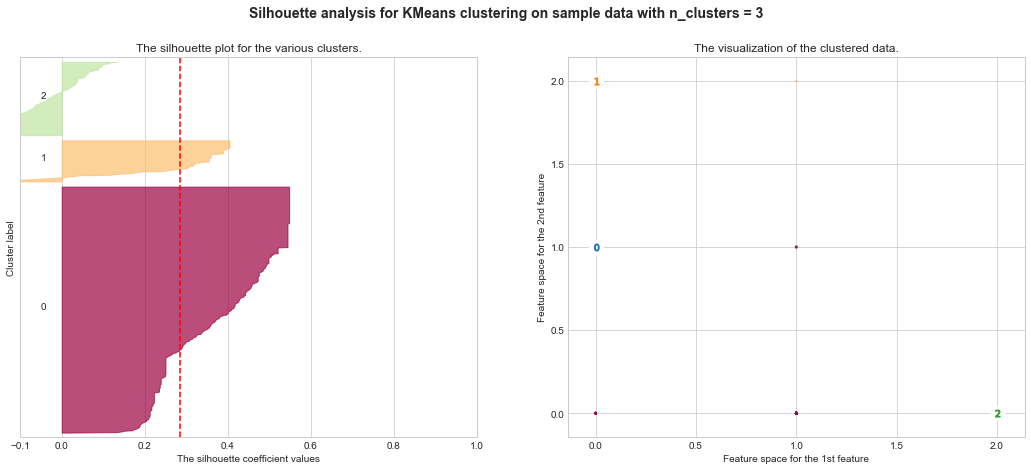

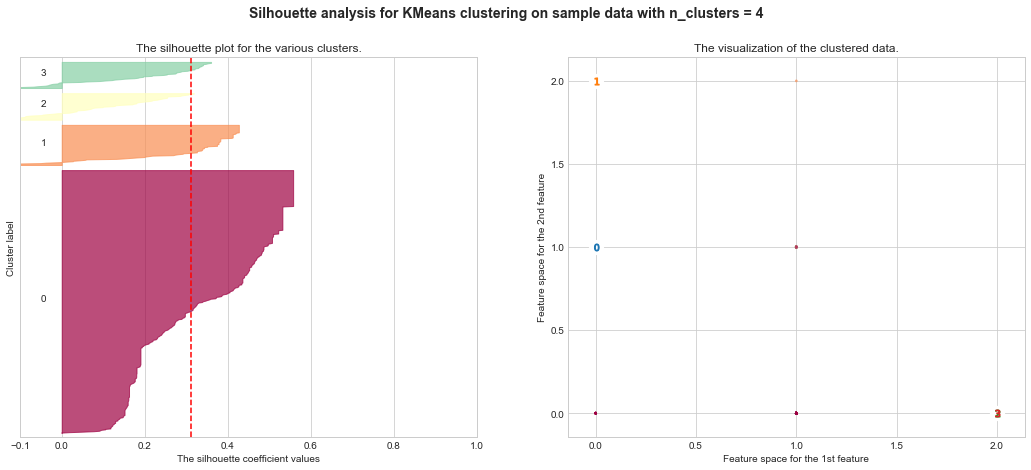

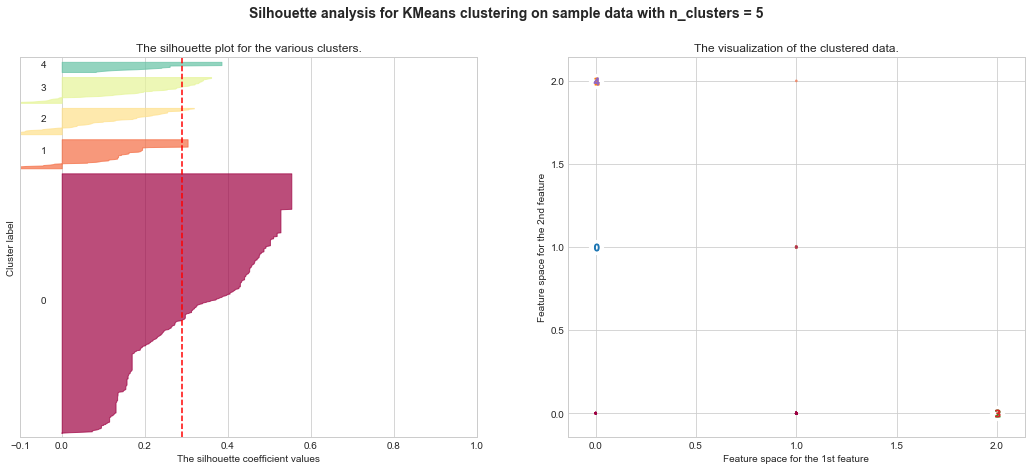

In [42]:
#little buddy test plots 

X_scaled=image_tags_df
plot_thing = []

for n_clusters in range(2,6):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    print ('!!**Trial Number '+ str(n_clusters))

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])
    
    clusterer = KModes(n_clusters=n_clusters, init='Cao', n_init=5, verbose=1)

    cluster_labels = clusterer.fit_predict(X_scaled)
    
    # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    
    plot_thing.append("For n_clusters =" + str(n_clusters)+
        " and the average silhouette_score is :"+ str(silhouette_avg))
    
  # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    
    
   
    y_lower = 10
    for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled.values[:, 0], X_scaled.values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centroids_
  # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
        
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')
    
    plt.show()

print(plot_thing)


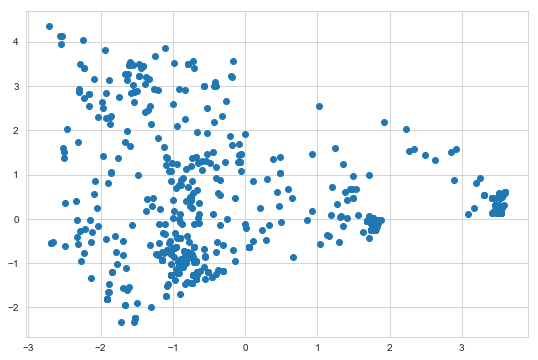

In [8]:
# Step 1: Choose your model class(es)
from sklearn.decomposition import PCA

# Step 2: Instantiate your model class(es)
pca = PCA(n_components=2)

# Step 3: Arrange data into features matrices
#image_tags_df

# Step 4: Fit the data and transform
X_pca = pca.fit_transform(image_tags_df)

# Plot the data
f,ax = plt.subplots(1,1,figsize=(9,6))
ax.scatter(X_pca[:,0],X_pca[:,1])

# for i,txt in enumerate(whr_2017_df['country'].values):
#     if txt == 'United States':
#         ax.annotate(txt,(X_pca[i,0],X_pca[i,1]),color='red',fontweight='bold')
#     else:
#         ax.annotate(txt,(X_mds[i,0],X_mds[i,1]))

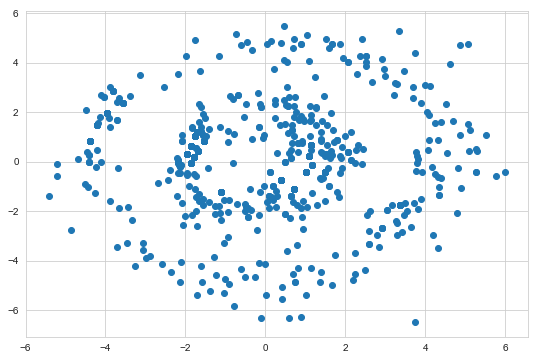

In [9]:
# Step 1: Choose your model class(es)
from sklearn.manifold import MDS

# Step 2: Instantiate your model class(es)
mds = MDS(n_components=2)

# Step 3: Arrange data into features matrices
# Done!

# Step 4: Fit the data and transform
X_mds = mds.fit_transform(image_tags_df)

# Plot the data
f,ax = plt.subplots(1,1,figsize=(9,6))
ax.scatter(X_mds[:,0],X_mds[:,1])

# for i,txt in enumerate(whr_2017_df['country'].values):
#     if txt == 'United States':
#         ax.annotate(txt,(X_mds[i,0],X_mds[i,1]),color='red',fontweight='bold')
#     else:
#         ax.annotate(txt,(X_mds[i,0],X_mds[i,1]))

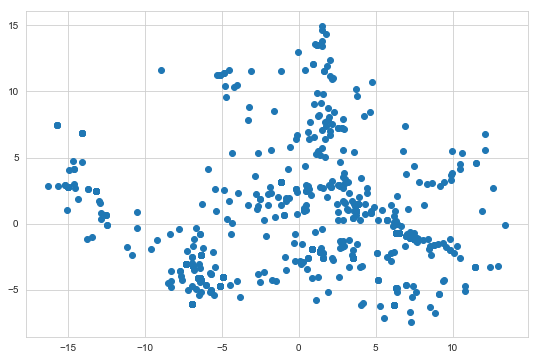

In [10]:
# Step 1: Choose your model class(es)
from sklearn.manifold import Isomap

# Step 2: Instantiate your model class(es)
iso = Isomap(n_neighbors = 5, n_components = 2)

# Step 3: Arrange data into features matrices
# Done!

# Step 4: Fit the data and transform
X_iso = iso.fit_transform(image_tags_df)


# Plot the data
f,ax = plt.subplots(1,1,figsize=(9,6))
ax.scatter(X_iso[:,0],X_iso[:,1])


# for i,txt in enumerate(whr_2017_df['country'].values):
#     if txt == 'United States':
#         ax.annotate(txt,(X_iso[i,0],X_iso[i,1]),color='red',fontweight='bold')
#     else:
#         ax.annotate(txt,(X_iso[i,0],X_iso[i,1]))

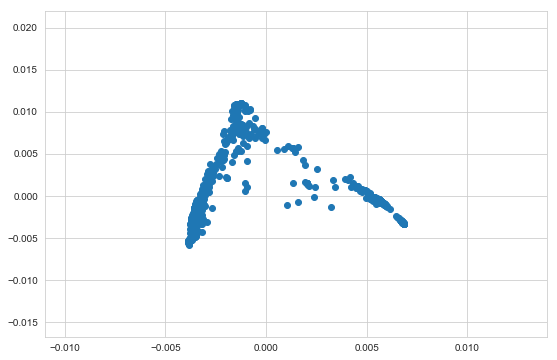

In [11]:
# Step 1: Choose your model class(es)
from sklearn.manifold import SpectralEmbedding

# Step 2: Instantiate your model class(es)
se = SpectralEmbedding(n_components = 2)

# Step 3: Arrange data into features matrices
# Done!

# Step 4: Fit the data and transform
X_se = se.fit_transform(image_tags_df)


# Plot the data
f,ax = plt.subplots(1,1,figsize=(9,6))
ax.scatter(X_se[:,0],X_se[:,1])

# for i,txt in enumerate(whr_2017_df['country'].values):
#     if txt == 'United States':
#         ax.annotate(txt,(X_se[i,0],X_se[i,1]),color='red',fontweight='bold')
#     else:
#         ax.annotate(txt,(X_se[i,0],X_se[i,1]))

In [86]:
# Step 1: Choose your model class(es)
from sklearn.manifold import TSNE

# Step 2: Instantiate your model class(es)
tsne = TSNE(n_components = 2, perplexity=30, n_iter=5000,learning_rate =30, random_state=42)
#tsne = TSNE(n_components = 2, metric='euclidean', init='pca')#, random_state=42)

# Step 3: Arrange data into features matrices
# Done!

# Step 4: Fit the data and transform
X_tsne = tsne.fit_transform(image_tags_df)



In [90]:
num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))
f,ax = plt.subplots(1,1,figsize=(9,6))
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=palette[colors.astype(np.int)], cmap='nipy_spectral',alpha=1)
ax.grid(None)

NameError: name 'num_classes' is not defined

/Users/emilyporter/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning:

invalid value encountered in sqrt



(0.4, 1)

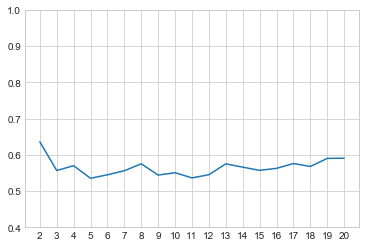

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_score = {}

for n in range(2,21):
    _model = KMeans(n_clusters=n)
    y = _model.fit_predict(X_tsne)
    sil_score[n] = silhouette_score(X_tsne,y)
    
ax = pd.Series(sil_score).plot()
ax.set_xticks(range(2,21));
ax.set_ylim((.4,1))

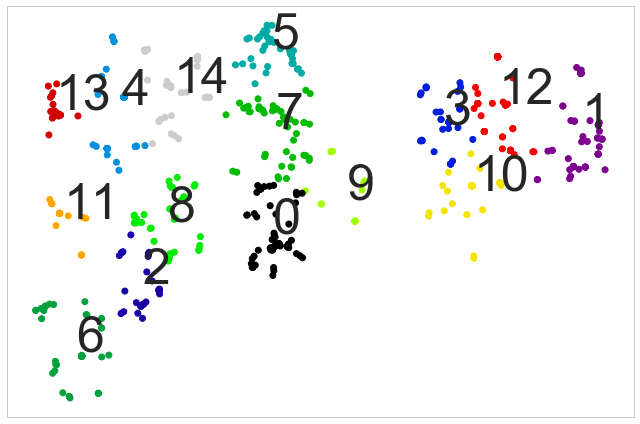

In [85]:
# Compute clusters
kmeans_clusters = KMeans(n_clusters=15)
kmeans_clusters.fit(X_tsne)
y_kmeans_clusters = kmeans_clusters.predict(X_tsne)
#image_tags_df['cluster'] = y_kmeans_clusters

repeated_image_tags_df = image_tags_df.reset_index()
repeated_image_tags_df['cluster'] = y_kmeans_clusters
repeated_image_tags_df['tsne_0'] = X_tsne[:,0]
repeated_image_tags_df['tsne_1'] = X_tsne[:,1]

# Visualize
f,ax = plt.subplots(1,1,figsize=(9,6))
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_kmeans_clusters, cmap='nipy_spectral',alpha=1)
ax.grid(None)

for cluster in range(kmeans_clusters.n_clusters):
    plt.annotate(str(cluster), 
                 (kmeans_clusters.cluster_centers_[cluster, 0], kmeans_clusters.cluster_centers_[cluster, 1]),
                 size=50
                );
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#ax.set_ylim((-50,60))
f.tight_layout()
f.savefig('tsne.pdf')

In [13]:
repeated_image_tags_df.groupby('cluster').agg({'image':len})

,image
cluster,
0,23
1,44
2,33
3,85
4,84
5,122
6,19
7,59
8,76


In [14]:
def df_euclidean(x):
    return euclidean([x['tsne_0'],x['tsne_1']],kmeans_clusters.cluster_centers_[x['cluster']])

repeated_image_tags_df['distance'] = repeated_image_tags_df.apply(lambda x:df_euclidean(x),axis=1)
representative_images = repeated_image_tags_df.loc[repeated_image_tags_df.groupby('cluster')['distance'].idxmin(),'image'].values
representative_images

array(['Location of Abkhazia in Europe2.png',
       'Romanian Revolution 1989 Corpses.jpg',
       'AngkorWat Delaporte1880.jpg',
       'Civilian with PM Md. 1963 during the Romanian....jpg',
       'Çevik Bir DD-SD-00-01007.jpg', 'David Dacko 1962 crop.jpg',
       'Oubangui-Chari.jpg',
       'George H. W. Bush and Boris Yeltsin 1993.jpg',
       '1991-Barrikad-BelyDom.jpg',
       'Presidential Standard of South Vietnam (1955-1963).png',
       "Coup-d'etat-9-web-cnni.jpg", 'Sputnik asm.jpg',
       'صورة دبابات الإنقلابيين العسكريين التركيين.jpg',
       'Tandja in Nigeria June 2007.jpg', 'Yameogo stamp 1960.png'],
      dtype=object)

FileNotFoundError: [Errno 2] No such file or directory: 'E:/Dropbox/Workspace/Wikipedia_images/Images/image_0.jpg'

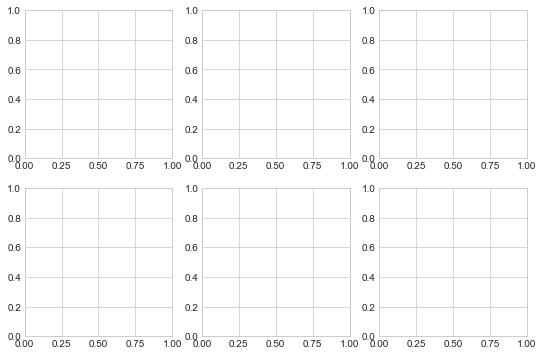

In [146]:
f,axs = plt.subplots(2,3,figsize=(9,6))

pos = 0

for r,row in enumerate(axs):
    for i,item in enumerate(row):
        try:
            im = plt.imread(_dir + 'Images/{0}'.format(representative_images[pos]))
            axs[r,i].imshow(im)
            axs[r,i].grid(None)
            axs[r,i].xaxis.set_visible(False)
            axs[r,i].yaxis.set_visible(False)
            axs[r,i].set_title(pos,size=25)
            pos += 1
        except:
            im = plt.imread(_dir + 'Images/image_0.jpg')
            axs[r,i].imshow(im)
            axs[r,i].grid(None)
            axs[r,i].xaxis.set_visible(False)
            axs[r,i].yaxis.set_visible(False)
            axs[r,i].set_title(pos,size=25)
            pos += 1
            pass
        
f.tight_layout()
f.savefig('tsne_cluster_images.pdf',dpi=600)

## Image usage

In [84]:
with open('all_coups_extlinks_usage.json','r') as f:
    external_links_usage = json.load(f)
    
with open('all_coups_file_image_usage.json','r') as f:
    all_coups_image_usage = json.load(f)
    
with open("all_coups_interlanguage_links.json",'r') as f:
    coup_interlanguage_links = json.load(f)

event_year_df = pd.read_csv('event_year.csv',encoding='utf8')

cols = ['IT-Active Image', 'IT-Passive Image',
        'D-Adult Male', 'D-Adult Female', 'D-Child Male', 'D-Child Female', 'D-Non-human', 
        'FE-Frown', 'FE-Smile', 
        'FPI-Foriegn Leaders', 'FPI-Foriegn Symbols',
        'GT-Alleged Atrocities', 'GT-Buildings', 'GT-Celebration', 'GT-Protest/Demonstration', 'GT-Destruction', 'GT-Diplomatic and Other Official Actions', 'GT-Documents/Communications', 'GT-Humanitarian Aid', 'GT-Locations/Maps/Infographics', 'GT-Memorials', 'GT-Military Actions', 'GT-Military Technology and Weaponry', 'GT-POWs', 'GT-Policing', 'GT-Portrait', 'GT-Signs/Symbols', 'GT-Suffering',
        'IF-Individual', 'IF-Group', 'IF-Individual in Relation to the Group', 'IF-Non-human',
        'TOP-Civilians', 'TOP-Journalists', 'TOP-Military or Political Leaders', 'TOP-Military Personnel', 'TOP-Police',
        'VI-Non-violent Image', 'VI-Violent Image']

In [64]:
topic_external_link_count_d = {}
for topic,topic_d in external_links_usage.items():
    for lang,lang_d in topic_d.items():
        topic_external_link_count_d[(topic,lang)] = len(lang_d)
        
topic_images_count_d = {}
for topic,topic_d in all_coups_image_usage.items():
    for lang,lang_d in topic_d.items():
        topic_images_count_d[(topic,lang)] = len(lang_d)
        
topic_internal_links_count_d = {}
for topic,topic_d in coup_interlanguage_links.items():
    for lang,lang_d in topic_d.items():
        topic_internal_links_count_d[(topic,lang)] = len(lang_d)

In [66]:
topic_external_link_count_df = pd.Series(topic_external_link_count_d).reset_index()
topic_external_link_count_df.columns = ['parent_topic','lang','external_links']

topic_images_count_df = pd.Series(topic_images_count_d).reset_index()
topic_images_count_df.columns = ['parent_topic','lang','images']

topic_internal_links_count_df = pd.Series(topic_images_count_d).reset_index()
topic_internal_links_count_df.columns = ['parent_topic','lang','internal_links']

In [122]:
_agg_func = {'user':pd.Series.nunique,'sha1':pd.Series.nunique,'size':np.max,'year':np.min}
topic_lang_activity_df = rev_df.groupby(['parent_topic','lang']).agg(_agg_func).reset_index()

image_usage_df = pd.merge(topic_lang_activity_df,topic_external_link_count_df,
                          left_on=['parent_topic','lang'],right_on=['parent_topic','lang'],how='outer')
image_usage_df = pd.merge(image_usage_df,topic_images_count_df,
                          left_on=['parent_topic','lang'],right_on=['parent_topic','lang'],how='outer')
image_usage_df = pd.merge(image_usage_df,topic_internal_links_count_df,
                          left_on=['parent_topic','lang'],right_on=['parent_topic','lang'],how='outer')
image_usage_df = pd.merge(image_usage_df,event_year_df,
                          left_on=['parent_topic'],right_on=['parent_topic'],how='outer')

image_usage_df.fillna(0,inplace=True)
#image_usage_df['event_year'] = image_usage_df['parent_topic'].str.extract(r'(\d{4})')
image_usage_df.columns = ['topic','lang','editors','revisions','size','created','external','images','internal','event']
image_usage_df['delay'] = image_usage_df['created'] - image_usage_df['event']
image_usage_df['has_image'] = (image_usage_df['images'] > 0).apply(int)
image_usage_df.head()

,topic,lang,editors,revisions,size,created,external,images,internal,event,delay,has_image
0,17 July Revolution,ar,29.0,54.0,7128.0,2007.0,0.0,0.0,0.0,1968,39.0,0
1,17 July Revolution,bn,2.0,3.0,5521.0,2015.0,1.0,0.0,0.0,1968,47.0,0
2,17 July Revolution,en,39.0,91.0,7593.0,2011.0,2.0,0.0,0.0,1968,43.0,0
3,17 July Revolution,es,3.0,4.0,2442.0,2014.0,2.0,0.0,0.0,1968,46.0,0
4,17 July Revolution,ja,5.0,5.0,4118.0,2013.0,1.0,0.0,0.0,1968,45.0,0


In [99]:
all_coups_image_usage['1991 Soviet coup d\'état attempt']['en'].keys()

dict_keys(['File:Boris Yeltsin 19 August 1991-1.jpg', 'File:Logo for Liberal Democratic Party of Russia.png', 'File:Bush Gorba P15623-25A.jpg', 'File:1991 coup attempt4.jpg', 'File:1991 coup attempt1.jpg'])

In [617]:
image_tags

{'Salah Bitar.jpg': {'GT-Military Technology and Weaponry': 0,
  'GT-Locations/Maps/Infographics': 0,
  'GT-Memorials': 0,
  'IT-Passive Image': 1,
  'D-Adult Male': 1,
  'GT-POWs': 0,
  'GT-Signs/Symbols': 0,
  'GT-Policing': 0,
  'IT-Active Image': 0,
  'GT-Diplomatic and Other Official Actions': 0,
  'TOP-Police': 0,
  'GT-Alleged Atrocities': 0,
  'GT-Humanitarian Aid': 0,
  'FPI-Foriegn Leaders': 0,
  'D-Child Female': 0,
  'VI-Non-violent Image': 1,
  'IF-Non-human': 0,
  'TOP-Military or Political Leaders': 1,
  'VI-Violent Image': 0,
  'D-Adult Female': 0,
  'FE-Smile': 0,
  'GT-Celebration': 0,
  'D-Non-human': 0,
  'GT-Suffering': 0,
  'GT-Destruction': 0,
  'GT-Military Actions': 0,
  'FE-Frown': 0,
  'TOP-Journalists': 0,
  'IF-Individual': 1,
  'FPI-Foriegn Symbols': 0,
  'GT-Protest/Demonstration': 0,
  'IF-Group': 0,
  'GT-Buildings': 0,
  'IF-Individual in Relation to the Group': 0,
  'D-Child Male': 0,
  'TOP-Military Personnel': 0,
  'TOP-Civilians': 0,
  'GT-Document

In [788]:
[i for i in image_tags_df.index if "Pedro Carmona" in i]

[]

In [789]:
bad_filename_mapping = {}
bad_filename_mapping['"De Historische Strijd" Herdenkingsmonument revolutie 25 februari 1980 - Nieuw-Amsterdam - 20418126 - RCE.jpg'] = '_De Historische Strijd_ Herdenkingsmonument....jpg'
bad_filename_mapping['1989 December 16. sugárút és a Tudor Vladimirescu út kereszteződése. Fortepan 31892.jpg'] = '1989 December 16. sugárút és a Tudor...kereszteződése. Fortepan 31892.jpg'
bad_filename_mapping['After coup nightly demonstartion of president Erdogan supporters. Istanbul, Turkey, Eastern Europe and Western Asia. 22 July,2016.jpg'] = 'After coup nightly demonstartion of presiden...Western Asia. 22 July,2016.jpg'
bad_filename_mapping['Air Commodore Kaiser Tufail receiving a memento from Commander of the Turkish Air Force General Akin Ozturk (cropped).jpg'] = 'Air Commodore Kaiser Tufail receiving a memento....jpg'
bad_filename_mapping['Air Commodore Kaiser Tufail receiving a memento from Commander of the Turkish Air Force General Akin Ozturk.jpg'] = 'Air Commodore Kaiser Tufail receiving....jpg'
bad_filename_mapping['Baath Party founder Michel Aflaq with Iraqi President Ahmad Hasan al-Bakr in Baghdad in 1968.jpg'] = 'Baath Party founder Michel Aflaq with Iraqi President....jpg'
bad_filename_mapping['Bundesarchiv B 145 Bild-F013047-0040, München, Staatsbesuch Präsident von Zypern.jpg'] = 'Bundesarchiv B 145 Bild-F013047-0040, München, ....jpg'
bad_filename_mapping['Bundesarchiv Bild 183-1989-1215-038, Berlin, Demonstration für Rumänien.jpg'] = 'Bundesarchiv Bild 183-1989-1215-038, Berlin, ....jpg'
bad_filename_mapping['Bundesarchiv Bild 183-1989-1220-032, Berlin, Demonstration für Rumänien, Mahnwache.jpg'] = 'Bundesarchiv Bild 183-1989-1220-032, Berlin, Demonstration....jpg'
bad_filename_mapping['Bundesarchiv Bild 183-1989-1221-032, Berlin, Demonstration für Rumänien.jpg'] = 'Bundesarchiv Bild 183-1989-1221-032, Berlin, Demonstration....jpg'
bad_filename_mapping['Bundesarchiv Bild 183-1989-1223-006, Berlin, Brandenburger Tor, Transparte zu Rumänien.jpg'] = 'Bundesarchiv Bild 183-1989-1223-006, Berlin, ....jpg'
bad_filename_mapping['Bundesarchiv Bild 183-1989-1120-036, Berlin, Schweigemarsch für Rumänien.jpg'] = 'Bundesarchiv Bild 183-1989-1120-036,....jpg'
bad_filename_mapping['Bundesarchiv Bild 183-55823-0005, Berlin, Karl-Marx-Allee, "Deutsche Sporthalle".jpg'] = 'Bundesarchiv Bild 183-55823-0005, Berlin, ....jpg'
bad_filename_mapping['Civilian with PM Md. 1963 during the Romanian Revolution of 1989.jpg'] = 'Civilian with PM Md. 1963 during the Romanian....jpg'
bad_filename_mapping['H.E. Mr. Mothetjoa Metsing, Deputy Prime Minister, Kingdom of Lesotho (8008839925) (cropped).jpg'] = 'H.E. Mr. Mothetjoa Metsing, Deputy Prime Minister....jpg'
bad_filename_mapping["Hashem al Atta, Khalid Hassan Abbas, 1971 Sudanese coup d'état.jpg"] = 'Hashem al Atta, Khalid Hassan Abbas, ....jpg'
bad_filename_mapping["Mayıs 1981 Kenan Evren Ankaragücü kaptanı Adil Eriç'e Türkiye Kupası'nı veriyor.jpg"] = 'Mayıs 1981 Kenan Evren Ankaragücü kaptanı....jpg'
bad_filename_mapping['Ninoy Aquino\'s "Testament from Prison Cell" signed by Cory Aquino in 1983.jpg'] = "Ninoy Aquino's _Testament from Prison Cell_ ....jpg"
bad_filename_mapping['Niwatthamrong Boonsongpaisan at Ministerial Conference 2013 crop.jpg'] = 'Niwatthamrong Boonsongpaisan at Ministerial....jpg'
bad_filename_mapping['Northrop YF-5A (SN 59-4987) with a full load of bombs 060905-F-1234S-002.jpg'] = 'Northrop YF-5A (SN 59-4987) with a full load....jpg'
bad_filename_mapping['People Power Revolution commemorative 10-peso coin obverse and reverse.png'] = 'People Power Revolution commemorative 10-peso coin....png'
bad_filename_mapping['President Barack Obama meets with members of his national security team, including Defense Secretary Chuck Hagel, to discuss the situation in Egypt, in the Situation Room of the White House, July 3, 2013.jpg'] = 'President Barack Obama meets with... July 3, 2013.jpg'
bad_filename_mapping['President Obama on the phone in the Oval Office with Secretary Kerry regarding the situation in Turkey (27716300004).jpg'] = 'President Obama on the phone in the Oval Office with... Turkey (27716300004).jpg'
bad_filename_mapping['RIAN archive 848095 Signing the Agreement to eliminate the USSR and establish the Commonwealth of Independent States.jpg'] = 'RIAN archive 848095 Signing the...Commonwealth of Independent States.jpg'
bad_filename_mapping['Secretary of Defense Chuck Hagel meets with Egyptian President Mohamed Morsy in Cairo, Egypt, April 24, 2013.jpg'] = 'Secretary of Defense Chuck Hagel meets with Egyptian....jpg'
bad_filename_mapping['Senior officials in the Baath Party in a rare un-official photograph with Salah Jadid from 1969.jpg'] = 'Senior officials in the Baath Party in a rare un-official....jpg'
bad_filename_mapping['Serie Portugal, verkiezingsstrijd in Lissabon (begin 1975); straatbeelden met verkiezingsaffiches.jpg'] = 'Serie Portugal, verkiezingsstrijd in Lissabon (begin 1975); ....jpg'
bad_filename_mapping['Thailand Ministry of Information and Communication Technology 2014 Censorship Image.jpg'] = 'Thailand Ministry of Information and ....jpg'
bad_filename_mapping['US Marine charges through Japanese machine gun fire on Okinawa.jpg'] = 'US Marine charges through Japanese machine....jpg'


In [790]:
topic_lang_image_tags_d = {}

bad_filenames = []

for topic, topic_d in all_coups_image_usage.items():
    for lang, lang_d in topic_d.items():
        _d = {}
        for image in lang_d.keys():
            filename = image.split(':')[-1]
            try:
                _d[filename] = image_tags_df.loc[filename]
            except KeyError:
                try:
                    revised_filename = bad_filename_mapping[filename]
                    _d[filename] = image_tags_df.loc[revised_filename]
                except:
                    bad_filenames.append(filename)
                pass
        topic_lang_image_tags_d[(topic,lang)] = pd.DataFrame(_d).sum(1)

set(bad_filenames)

{'BP200906-2.jpg',
 'Bakr.jpg',
 'Defence.jpg',
 'Genesis FUBELT.jpg',
 'Hameed.png',
 'July1.jpg',
 'Last day qasim.jpg',
 'Mhdawi.jpg',
 'Operacio marverde.jpg',
 'Pedro Carmona 2002 darbesinden sonra yemin töreninde.jpg',
 'Plevne Marşı pul.jpg',
 'Qasim arif.jpg',
 'Qasim2.jpg',
 'Rafiq1.jpg',
 'RafiqArif.jpg',
 'Revolutie-strada-multime.jpg',
 'Sallama.png',
 'Taher yahya.jpg',
 'The nation 200506.jpg',
 'Trial iraq.jpg',
 'Watanyin.jpg',
 'Казнь Касема.jpg'}

In [791]:
topic_lang_image_tags_df = pd.DataFrame(topic_lang_image_tags_d).T.fillna(0).reset_index()
topic_lang_image_tags_df.rename(columns={'level_0':'topic','level_1':'lang'},inplace=True)

#topic_lang_image_tags_df = pd.merge(image_usage_df,topic_lang_image_tags_df,
#                                    left_on=['topic','lang'],right_on=['topic','lang'],how='outer')

#nonzero_topic_lang_image_tags_df = topic_lang_image_tags_df[topic_lang_image_tags_df['images'] > 0]

#topic_lang_image_tags_df.to_csv('topic_lang_image_tags.csv',index=False,encoding='utf8')
#nonzero_topic_lang_image_tags_df.to_csv('topic_lang_image_tags_nonzero.csv',index=False,encoding='utf8')

In [793]:
topic_lang_image_tags_df.columns[2:]

Index(['Active', 'Adult Male', 'Adult female', 'Alleged atrocities',
       'Buildings', 'Celebrations', 'Child female', 'Child male', 'Civilians',
       'Demographics - Cannot discern*', 'Demographics - Non-human ',
       'Demonstrations', 'Deplomacy', 'Destruction', 'Documents',
       'Facial Expression - N/A', 'Facial expression - Unclear*',
       'Foreign Influence - N/A', 'Foreign flag', 'Foreign leaders', 'Frown',
       'GT - Other*', 'Group ', 'Humanitarian aid', 'Image focus - Non-human',
       'Image focus - Unclear* ', 'Individual', 'Individual in group',
       'Infographics/maps', 'Journalists', 'Memorials', 'Military Actions',
       'Military personnel', 'Military technology',
       'Military/political leaders', 'Non-violent', 'Passive', 'Police',
       'Portraits', 'Prisoners/arrest', 'Signs/symbols', 'Smile', 'Suffering',
       'Type of people - Unclear*', 'Types of people - N/A', 'Violent'],
      dtype='object')

In [816]:
sum_lang_image_tags_df = topic_lang_image_tags_df.groupby('lang').agg({c:np.sum for c in topic_lang_image_tags_df.columns[2:]})
sum_lang_image_tags_df = sum_lang_image_tags_df[sum_lang_image_tags_df.sum(1) > 1]
#sum_lang_image_tags_df = sum_lang_image_tags_df.apply(np.log1p)
#sum_lang_image_tags_df = sum_lang_image_tags_df.gt(0)

In [817]:
# Step 1: Choose your model class(es)
#from sklearn.manifold import TSNE

# Step 2: Instantiate your model class(es)
lang_tsne = TSNE(n_components = 2, method='exact', init='pca')#, perplexity=10)

# Step 3: Arrange data into features matrices
# Done!

# Step 4: Fit the data and transform
X_lang_tsne = lang_tsne.fit_transform(sum_lang_image_tags_df)

(0.3, 1)

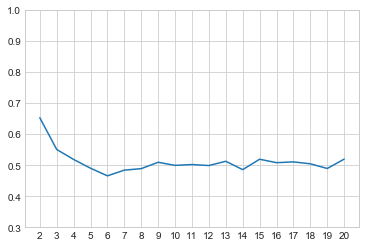

In [818]:
sil_score = {}

for n in range(2,21):
    _model = KMeans(n_clusters=n)
    y_lang = _model.fit_predict(X_lang_tsne)
    sil_score[n] = silhouette_score(X_lang_tsne,y_lang)
    
ax = pd.Series(sil_score).plot()
ax.set_xticks(range(2,21));
ax.set_ylim((.3,1))

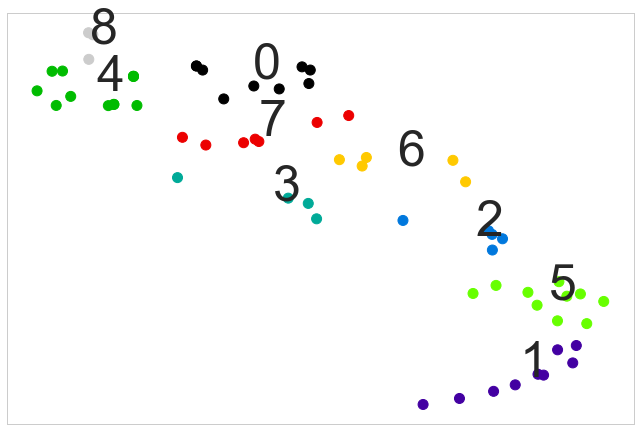

In [843]:
# Compute clusters
lang_kmeans_clusters = KMeans(n_clusters=9)
lang_kmeans_clusters.fit(X_lang_tsne)
y_lang_kmeans_clusters = lang_kmeans_clusters.predict(X_lang_tsne)
#image_tags_df['cluster'] = y_lang_kmeans_clusters

repeated_sum_lang_image_tags_df = sum_lang_image_tags_df
repeated_sum_lang_image_tags_df['cluster'] = y_lang_kmeans_clusters
repeated_sum_lang_image_tags_df['tsne_0'] = X_lang_tsne[:,0]
repeated_sum_lang_image_tags_df['tsne_1'] = X_lang_tsne[:,1]

# Visualize
f,ax = plt.subplots(1,1,figsize=(9,6))
ax.scatter(X_lang_tsne[:, 0], X_lang_tsne[:, 1], c=y_lang_kmeans_clusters, cmap='nipy_spectral',alpha=1,s=100)
ax.grid(None)

for cluster in range(lang_kmeans_clusters.n_clusters):
    plt.annotate(str(cluster), 
                 (lang_kmeans_clusters.cluster_centers_[cluster, 0], lang_kmeans_clusters.cluster_centers_[cluster, 1]),
                 size=50
                );
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#ax.set_ylim((-50,60))
f.tight_layout()
f.savefig('tsne_lang.pdf')

In [855]:
list(enumerate(repeated_sum_lang_image_tags_df.reset_index().groupby('cluster').agg({'lang':lambda x:list(x)})['lang'].values))

[(0, ['be-x-old', 'hr', 'lb', 'lv', 'nn', 'oc', 'simple', 'ta', 'tet']),
 (1, ['ar', 'de', 'en', 'es', 'fr', 'ja', 'pl', 'pt', 'ru']),
 (2, ['fa', 'ka', 'nl', 'no', 'ro']),
 (3, ['br', 'fi', 'id', 'sv']),
 (4,
  ['af',
   'azb',
   'cy',
   'et',
   'is',
   'lt',
   'ms',
   'sco',
   'si',
   'sk',
   'sl',
   'zh-yue']),
 (5, ['ca', 'gl', 'he', 'it', 'ko', 'th', 'tr', 'uk', 'vi', 'zh']),
 (6, ['bg', 'bn', 'da', 'hu', 'sr']),
 (7, ['az', 'cs', 'el', 'eo', 'eu', 'sh', 'tl']),
 (8, ['ckb', 'mk', 'tg'])]

### 1991 Soviet case study

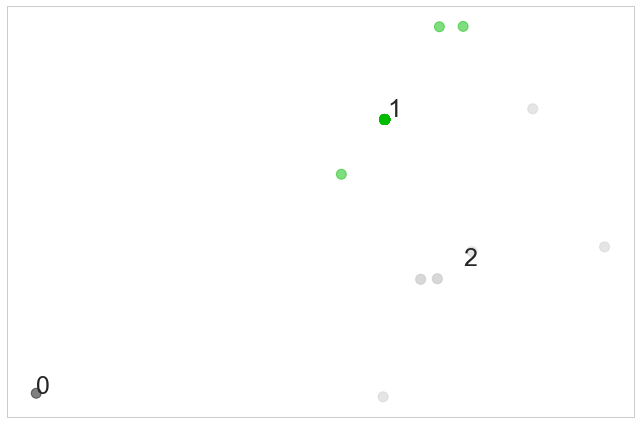

In [825]:
soviet_lang_image_tags_df = topic_lang_image_tags_df.set_index(['topic','lang']).loc["1991 Soviet coup d'état attempt"]

X_soviet_tsne = lang_tsne.fit_transform(soviet_lang_image_tags_df)

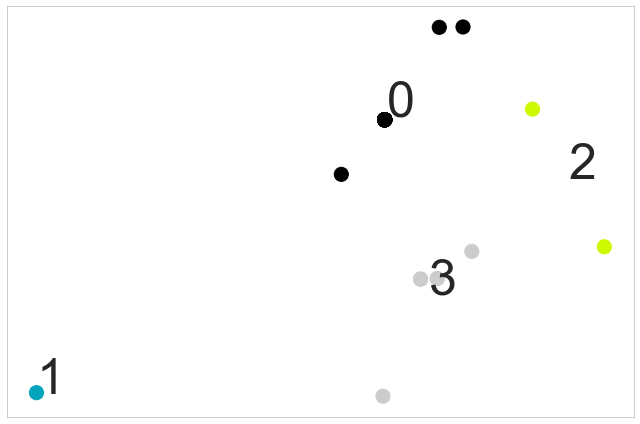

In [842]:
# Compute clusters
soviet_kmeans_clusters = KMeans(n_clusters=4)
soviet_kmeans_clusters.fit(X_soviet_tsne)
y_soviet_kmeans_clusters = soviet_kmeans_clusters.predict(X_soviet_tsne)

# Put clusters and embedding coordinates into a DF
repeated_soviet_lang_image_tags_df = soviet_lang_image_tags_df
repeated_soviet_lang_image_tags_df['cluster'] = y_soviet_kmeans_clusters
repeated_soviet_lang_image_tags_df['tsne_0'] = X_soviet_tsne[:,0]
repeated_soviet_lang_image_tags_df['tsne_1'] = X_soviet_tsne[:,1]

# Visualize
f,ax = plt.subplots(1,1,figsize=(9,6))
ax.scatter(X_soviet_tsne[:, 0], X_soviet_tsne[:, 1], c=y_soviet_kmeans_clusters, cmap='nipy_spectral',alpha=1,s=200)
ax.grid(None)

for cluster in range(soviet_kmeans_clusters.n_clusters):
    plt.annotate(str(cluster), 
                 (soviet_kmeans_clusters.cluster_centers_[cluster, 0], soviet_kmeans_clusters.cluster_centers_[cluster, 1]),
                 size=50
                );
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#ax.set_ylim((-50,60))
f.tight_layout()
f.savefig('tsne_soviet.pdf')

In [859]:
len(['de', 'lmo', 'sr', 'mk', 'ro', 'pl', 'cv', 'lv', 'da', 'hr', 'it', 'ky', 'et', 'mn', 'ko', 'he', 'bg', 'eo', 'tt', 'fa', 'ar', 'ca', 'kk', 'th', 'en', 'zh', 'sv', 'id', 'eu', 'be', 'uk', 'cs', 'nl', 'zh-yue', 'be-x-old'])

35

In [856]:
repeated_soviet_lang_image_tags_df.reset_index().groupby('cluster').agg({'lang':lambda x:list(x)})['lang'].values

array([list(['de', 'lmo', 'sr', 'mk', 'ro', 'pl', 'cv', 'lv', 'da', 'hr', 'it', 'ky', 'et', 'mn', 'ko', 'he', 'bg', 'eo', 'tt', 'fa', 'ar', 'ca', 'kk', 'th', 'en', 'zh', 'sv', 'id', 'eu', 'be', 'uk', 'cs', 'nl', 'zh-yue', 'be-x-old']),
       list(['ru']), list(['ja', 'es']),
       list(['tr', 'no', 'vi', 'fr', 'fi', 'pt'])], dtype=object)

### 2013 Egyptian case study

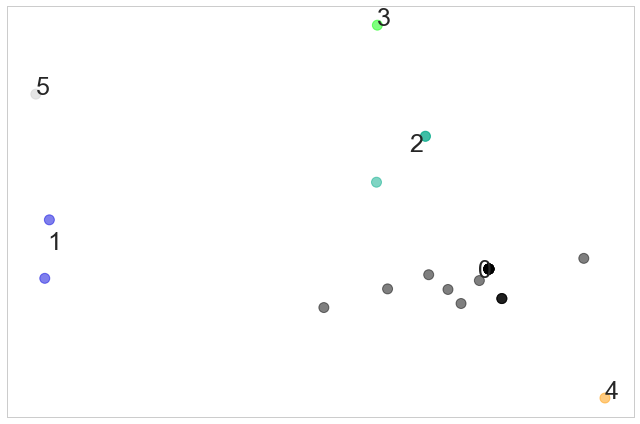

In [830]:
egypt_lang_image_tags_df = topic_lang_image_tags_df.set_index(['topic','lang']).loc["2013 Egyptian coup d'état"]

X_egypt_tsne = lang_tsne.fit_transform(egypt_lang_image_tags_df)

# Compute clusters
egypt_kmeans_clusters = KMeans(n_clusters=6)
egypt_kmeans_clusters.fit(X_egypt_tsne)
y_egypt_kmeans_clusters = egypt_kmeans_clusters.predict(X_egypt_tsne)

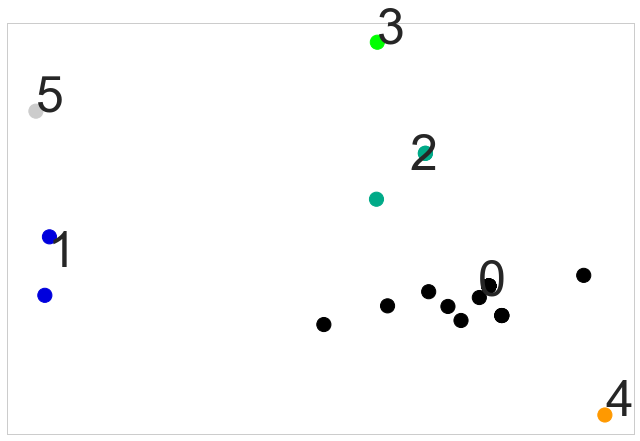

In [841]:
# Put clusters and embedding coordinates into a DF
repeated_egypt_lang_image_tags_df = egypt_lang_image_tags_df
repeated_egypt_lang_image_tags_df['cluster'] = y_egypt_kmeans_clusters
repeated_egypt_lang_image_tags_df['tsne_0'] = X_egypt_tsne[:,0]
repeated_egypt_lang_image_tags_df['tsne_1'] = X_egypt_tsne[:,1]

# Visualize
f,ax = plt.subplots(1,1,figsize=(9,6))
ax.scatter(X_egypt_tsne[:, 0], X_egypt_tsne[:, 1], c=y_egypt_kmeans_clusters, cmap='nipy_spectral',alpha=1,s=200)
ax.grid(None)

for cluster in range(egypt_kmeans_clusters.n_clusters):
    plt.annotate(str(cluster), 
                 (egypt_kmeans_clusters.cluster_centers_[cluster, 0], egypt_kmeans_clusters.cluster_centers_[cluster, 1]),
                 size=50
                );
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#ax.set_ylim((-50,60))
f.tight_layout()
f.savefig('tsne_egypt.pdf')

In [862]:
len(['tr', 'bg', 'de', 'el', 'nl', 'sr', 'ro', 'pl', 'az', 'ru', 'ca', 'vi', 'ckb', 'zh', 'it', 'id', 'es', 'uk', 'arz', 'af', 'pt', 'fi', 'ur', 'hi']),len(repeated_egypt_lang_image_tags_df)

(24, 32)

In [860]:
repeated_egypt_lang_image_tags_df.reset_index().groupby('cluster').agg({'lang':lambda x:list(x)})['lang'].values

array([list(['tr', 'bg', 'de', 'el', 'nl', 'sr', 'ro', 'pl', 'az', 'ru', 'ca', 'vi', 'ckb', 'zh', 'it', 'id', 'es', 'uk', 'arz', 'af', 'pt', 'fi', 'ur', 'hi']),
       list(['fa', 'ar']), list(['he', 'ja', 'fr']), list(['en']),
       list(['tg']), list(['ko'])], dtype=object)

## Image tag similarity

In [347]:
good_tags = [i for i in image_tags_df.columns if i != 'cluster']

In [362]:
cosine_similiarty_d = dict()

for image1 in image_tags_df.index:
    cosine_similiarty_d[image1] = {}
    for image2 in image_tags_df.index:
        cosine_similiarty_d[image1][image2] = cosine(image_tags_df.loc[image1,good_tags],
                                                     image_tags_df.loc[image2,good_tags])

with open('image_tag_cosine_similarity.json','w') as f:
    json.dump(cosine_similiarty_d,f)

In [371]:
cosine_similiarty_df = pd.DataFrame(cosine_similiarty_d).stack().reset_index()
cosine_similiarty_df.groupby(['level_0','level_1']).head(5)

,level_0,level_1,0
0,"""De Historische Strijd"" Herdenkingsmonument re...",Salah Bitar.jpg,0.634852
1,"""De Historische Strijd"" Herdenkingsmonument re...",Desi Bouterse.jpg,0.661938
2,"""De Historische Strijd"" Herdenkingsmonument re...",National Revolutionary Command Council (Sudan)...,0.661938
3,"""De Historische Strijd"" Herdenkingsmonument re...",2009 Honduras political crisis 9.jpg,0.850929
4,"""De Historische Strijd"" Herdenkingsmonument re...",By-map.png,0.329180
5,"""De Historische Strijd"" Herdenkingsmonument re...",Iskander Mirza.jpg,0.634852
6,"""De Historische Strijd"" Herdenkingsmonument re...",EDSA_Revolution_pic1.jpg,0.800000
7,"""De Historische Strijd"" Herdenkingsmonument re...",Iraq14.jpg,0.200000
8,"""De Historische Strijd"" Herdenkingsmonument re...",Assemblee Nationale Burkina Faso.jpg,0.329180
9,"""De Historische Strijd"" Herdenkingsmonument re...",Nguyễn Khánh 1964.jpg,0.634852


## Appendix

### Trying to fix broken tags

In [5]:
lang_image_tags = {}
bad_files = list()

for lang, filelist in lang_images.items():
    lang_image_tags[lang] = []
    for file in filelist:
        try:
            tags = image_tags_dict[file]
        except KeyError:
            try:
                tags = image_tags_dict[file.replace(' ','_')]
            except KeyError:
                bad_files.append(file)
            
len(bad_files)

239

In [76]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [82]:
edit_distance = {}
for f1 in list(set([f for lang,files in lang_images.items() for f in files])):
    edit_distance[f1] = {}
    for f2 in list(set(image_tags_dict.keys())):
        if abs(len(f1) - len(f2)) < 5 and f1 != f2:
            dist =  levenshtein(f1,f2)
            if dist < 5:
                edit_distance[f1][f2] = dist
        

In [11]:
with open('scraped_image_filenames.json','w') as f:
    json.dump(sorted(list(set([f for lang,files in lang_images.items() for f in files]))),f)
    
with open('tagged_image_filenames.json','w') as f:
    json.dump(sorted(list(set(image_tags_dict.keys()))),f)

In [10]:
len(list(set(image_tags_dict.keys()))), len(list(set([f for lang,files in lang_images.items() for f in files])))

(774, 747)

In [13]:
with open('tagged_scraped_disjoint_filenames.json','w') as f:
    json.dump(sorted(list(set([f for lang,files in lang_images.items() for f in files]) ^ set(image_tags_dict.keys()))),f)



In [73]:
set(image_tags_dict.keys()) - set([f for lang,files in lang_images.items() for f in files])

{'-De_Historische_Strijd-_Herdenkingsmonument_revolutie_25_februari_1980_-_Nieuw-Amsterdam_-_20418127_-_RCE.jpg',
 '15 July-Erdoğan SMS.jpg',
 '15 Temmuz Şehitler Parkı tabelası.jpg',
 "1962 Burmese coup d'état.jpg",
 "1962 Burmese coup d'état2.jpg",
 '1989 December 16. sugárút és a Tudor Vladimirescu út kereszteződése. Fortepan 31892.jpg',
 '1991_coup_yeltsin.jpg',
 "1992 Venezuelan coup d'état attempts Hugo Chávez speech.jpg",
 "1992 Venezuelan coup d'état attempts Miraflores.jpg",
 "1992 Venezuelan coup d'état attempts collage.png",
 '1993_Rusya_anayasa_krizi_sırasında_Parlamento_yanlısı_göstericiler.jpg',
 '1993_Tanks_before_Russian_White_house.jpg',
 '1_Mart_1997_-_Cumhuriyet.jpg',
 "2002 Venezuelan coup d'état attempt collage.jpg",
 "2002 Venezuelan coup d'état attempt uprising.jpg",
 '200535.jpg',
 '2007ManilaPenSiegeMap.jpg',
 '2014 Suchum, Siedziba rządu i prezydenta Republiki Abchazji (04).jpg',
 '2016 Türkiye Darbe Girişimi - Ankara.jpg',
 "20th anniversa